testing track metrics

In [1]:
import sys,os,os.path
sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize

import core.functions as func

import random



### nice functions

In [2]:

def threshold_hits(threshold_charge, same_peak, hitc):
    """
    Applies a threshold to hits and redistributes the charge/energy.

    Parameters
    ----------
    threshold_charge : float
        minimum pes of a hit
    same_peak        : bool
        whether to reassign NN hits' energy only to the hits from the same peak

    Returns
    ----------
    A function that takes HitCollection as input and returns another object with
    only non NN hits of charge above threshold_charge.
    The energy of NN hits is redistributed among neighbors.
    """

    t = hitc.time
    thr_hits = hif.threshold_hits(hitc.hits, threshold_charge     )
    mrg_hits = hif.merge_NN_hits ( thr_hits, same_peak = same_peak)

    cor_hits = []
    for hit in mrg_hits:
        cluster = Cluster(hit.Q, xy(hit.X, hit.Y), hit.var, hit.nsipm)
        xypos   = xy(hit.Xpeak, hit.Ypeak)
        hit     = Hit(hit.npeak, cluster, hit.Z, hit.E, xypos, hit.Ec)
        cor_hits.append(hit)

    new_hitc      = HitCollection(hitc.event, t)
    new_hitc.hits = cor_hits
    return new_hitc





def hits_from_df (dst, skip_NN = False):
    """
    Function that transforms pandas DataFrame dst to HitCollection
    ------
    Parameters
    ------
    dst : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
        If time, nsipm, Xrms, Yrms, Qc, Ec, track_id are not
        inside dst the default value is set to -1
        If Xpeak, Ypeak not in dst the default value is -1000
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    https://github.com/next-exp/IC/blob/v2-development/invisible_cities/io/hits_io.py#L16
    """
    all_events = {}
    times = getattr(dst, 'time', [-1]*len(dst))
    for (event, time) , df in dst.groupby(['event', times]):
        #pandas is not consistent with numpy dtypes so we have to change it by hand
        event = np.int32(event)
        hits  = []
        for i, row in df.iterrows():
            Q = getattr(row,'Q', row.E)
            if skip_NN and Q == NN:
                continue
            if hasattr(row, 'Xrms'):
                Xrms  = row.Xrms
                Xrms2 = Xrms**2
            else:
                Xrms = Xrms2 = -1
            if hasattr(row, 'Yrms'):
                Yrms  = row.Yrms
                Yrms2 = Yrms**2
            else:
                Yrms = Yrms2 = -1
            nsipm   = getattr(row, 'nsipm'   , -1   )     # for backwards compatibility
            Qc      = getattr(row, 'Qc'      , -1   )     # for backwards compatibility
            Xpeak   = getattr(row, 'Xpeak'   , -1000)     # for backwards compatibility
            Ypeak   = getattr(row, 'Ypeak'   , -1000)     # for backwards compatibility
            Ec      = getattr(row, 'Ec'      , -1   )     # for backwards compatibility
            trackID = getattr(row, 'track_id', -1   )     # for backwards compatibility
            Ep      = getattr(row, "Ep"      , -1   )     # for backwards compatibility

            hit = Hit(row.npeak            ,
                      Cluster(Q               ,
                              xy(row.X, row.Y),
                              xy(Xrms2, Yrms2),
                              nsipm = nsipm   ,
                              z     = row.Z   ,
                              E     = row.E   ,
                              Qc    = Qc      ),
                      row.Z                ,
                      row.E                ,
                      xy(Xpeak, Ypeak)     ,
                      s2_energy_c = Ec     ,
                      track_id    = trackID,
                      Ep          = Ep     )

            hits.append(hit)

        if len(hits):
            all_events[event] = HitCollection(event, time, hits=hits)

    return all_events

def hitc_to_df_(hitc):
    columns = defaultdict(list)
    for hit in hitc.hits:
        columns["event"   ].append(hitc.event)
        columns["time"    ].append(hitc.time)
        columns["npeak"   ].append(hit .npeak)
        columns["Xpeak"   ].append(hit .Xpeak)
        columns["Ypeak"   ].append(hit .Ypeak)
        columns["nsipm"   ].append(hit .nsipm)
        columns["X"       ].append(hit .X)
        columns["Y"       ].append(hit .Y)
        columns["Xrms"    ].append(hit .Xrms)
        columns["Yrms"    ].append(hit .Yrms)
        columns["Z"       ].append(hit .Z)
        columns["Q"       ].append(hit .Q)
        columns["E"       ].append(hit .E)
        columns["Qc"      ].append(hit .Qc)
        columns["Ec"      ].append(hit .Ec)
        columns["track_id"].append(hit .track_id)
        columns["Ep"      ].append(hit .Ep)
    return pd.DataFrame(columns)






def soph_to_lowTh(df, threshold = 5, verbose = True):
    '''
    Converts sophronia 'RECO/Events' to lowTh events via a rather convoluted process
    Made by me (John Waiton), so dont treat it like a normal function from IC!
    ------
    Parameters
    ------
    df : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
    threshold: int
        value at which the threshold is set.
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    '''



    # new parameters for threshold, this is silly but I'm copying previous convention
    pes = 1
    threshold = threshold * pes
    same_peak = True

    # convert sophronia RECO/Events to hit collection
    soph_hitc = hits_from_df(df)

    # collect the keys as the event numbers
    soph_hitc_list = list(soph_hitc.keys())
    if (verbose == True):
        print("Processing data...")
    # loop over all of these events
    j = 0
    for i in soph_hitc_list:
        j += 1

        if (verbose == True):
            if (len(soph_hitc_list)%j == 50): 
                print("{}/{}".format(j, len(soph_hitc_list)))
        # choose i'th event
        soph_hit_event = soph_hitc.get(i)

        # Apply threshold calculation
        soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

        # convert back to pandas dataframe using hitc_to_df
        soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

        # check if pandas dataframe with all the events exists yet
        if 'full_soph_df' in locals() and isinstance(full_soph_df, pd.DataFrame):
            full_soph_df = pd.concat([full_soph_df, soph_hdst_lowTh])
        else:
            full_soph_df = soph_hdst_lowTh.copy(deep = True)
    
    return full_soph_df

In [3]:
# set the seed if you find nice events
random.seed(10)

### load in relevant sophronia file

In [4]:
file_1 = 'testing_data/sophronia_128_208Tl.h5'
file_2 = 'testing_data/sophronia_129_208Tl.h5'
file_3 = 'testing_data/sophronia_130_208Tl.h5'

In [5]:
# LOAD DATA
data = dstio.load_dst(file_1, 'RECO', 'Events')
df_ps = pd.read_hdf(file_1, 'MC/particles')

event_list = (data['event'].unique())

In [6]:
# scrape some positron events
pos_df = func.from_file_positron(file_1)

In [7]:
print("{}/{} events are signal".format(len(pos_df.index),len(event_list)))
signal_id = pos_df['event_id'].to_numpy()

53/339 events are signal


In [8]:
display(df_ps)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
0,1270000,1,Tl208,True,0,396.540802,394.971252,536.123352,0.000000,396.540802,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,none,RadioactiveDecay
1,1270000,4,e-,False,1,396.540802,394.971252,536.123352,0.000514,396.552490,...,0.002595,0.132775,0.439125,-0.000000,0.000000,-0.000000,0.175723,2.080215e+00,RadioactiveDecay,eIoni
2,1270000,3,anti_nu_e,False,1,396.540802,394.971252,536.123352,0.000514,-12500.000000,...,-1.443441,-0.444728,0.600621,-1.443441,-0.444728,0.600621,1.625438,1.452261e+04,RadioactiveDecay,Transportation
3,1270000,2,Pb208[3197.711],False,1,396.540802,394.971252,536.123352,0.000514,396.540802,...,1.440844,0.311953,-1.039745,0.000000,0.000000,-0.000000,0.000008,0.000000e+00,RadioactiveDecay,RadioactiveDecay
4,1270000,6,gamma,False,2,396.540802,394.971252,536.123352,0.000514,248.638458,...,-0.117886,-0.370464,0.434704,-0.000000,-0.000000,0.000000,0.583188,7.316822e+02,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27397,1270343,63,e-,False,59,383.083252,404.562683,520.891968,0.072662,383.083252,...,-0.002171,-0.000586,0.007362,0.000000,-0.000000,-0.000000,0.000058,1.447787e-07,phot,msc
27398,1270343,62,e-,False,59,383.083252,404.562683,520.891968,0.072662,383.083252,...,0.012554,-0.024946,-0.009436,0.000000,-0.000000,-0.000000,0.000850,1.402082e-05,phot,eIoni
27399,1270343,61,e-,False,59,383.083252,404.562683,520.891968,0.072662,383.083191,...,-0.063734,0.031759,0.046704,-0.000000,0.000000,-0.000000,0.007047,2.941332e-04,phot,eIoni
27400,1270343,58,e-,False,57,383.077148,404.553497,520.887756,0.072622,383.077301,...,0.108280,0.027625,-0.028822,0.000000,-0.000000,0.000000,0.012870,8.100217e-04,phot,eIoni


In [9]:
display(signal_id)

array([1270003, 1270007, 1270011, 1270017, 1270026, 1270031, 1270037,
       1270041, 1270046, 1270047, 1270049, 1270050, 1270055, 1270056,
       1270069, 1270086, 1270090, 1270107, 1270111, 1270119, 1270122,
       1270123, 1270130, 1270136, 1270138, 1270144, 1270148, 1270160,
       1270164, 1270169, 1270172, 1270174, 1270187, 1270191, 1270193,
       1270210, 1270221, 1270263, 1270265, 1270273, 1270274, 1270275,
       1270278, 1270280, 1270281, 1270291, 1270295, 1270299, 1270306,
       1270313, 1270335, 1270336, 1270339])

### lets choose some random signal events from the list

In [10]:
sig_evt_id = []

for i in range(0,5):
    sig_evt_id.append(random.choice(signal_id*2))
    print("Event chosen, ID: {}".format(sig_evt_id[i]))

Event chosen, ID: 2540442
Event chosen, ID: 2540022
Event chosen, ID: 2540320
Event chosen, ID: 2540344
Event chosen, ID: 2540442


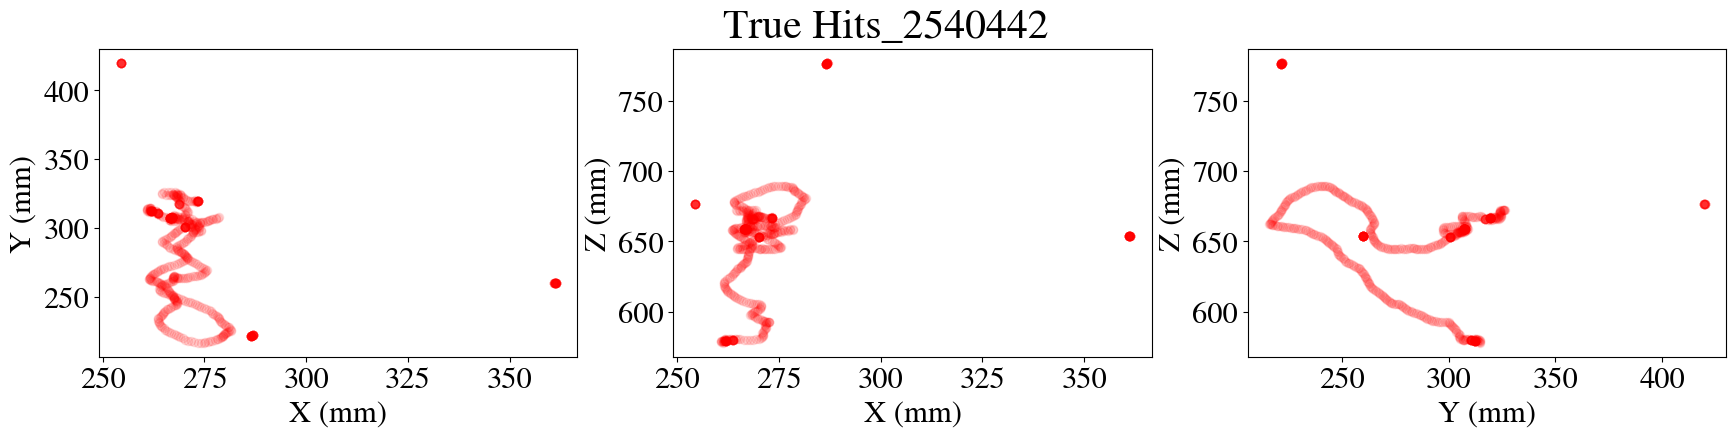

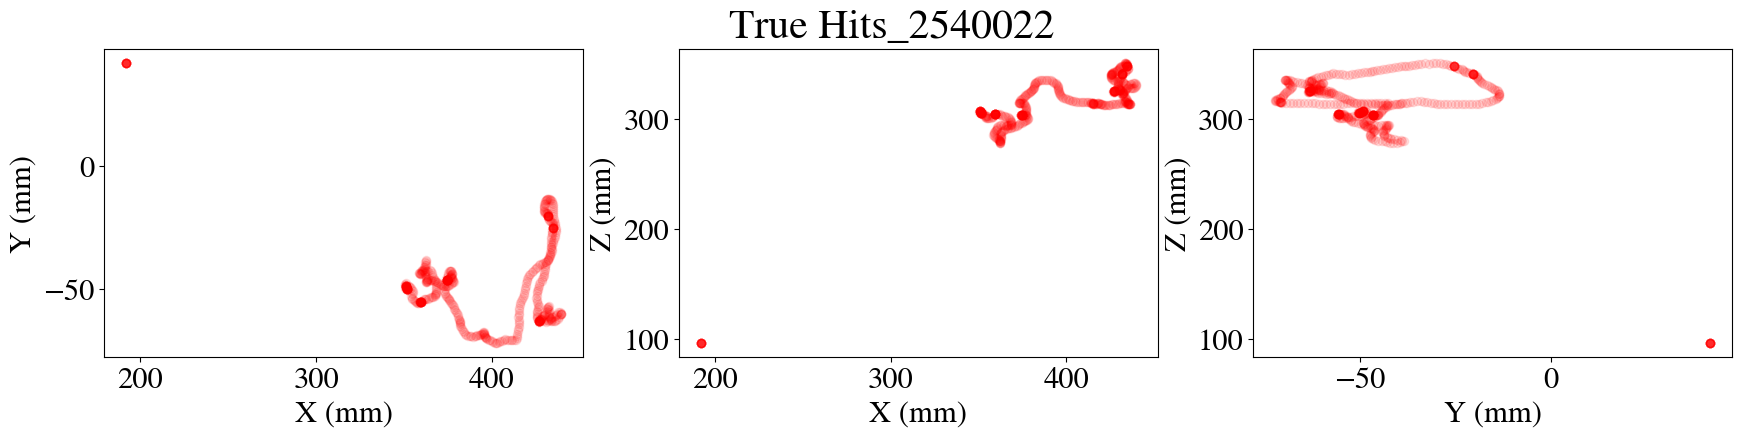

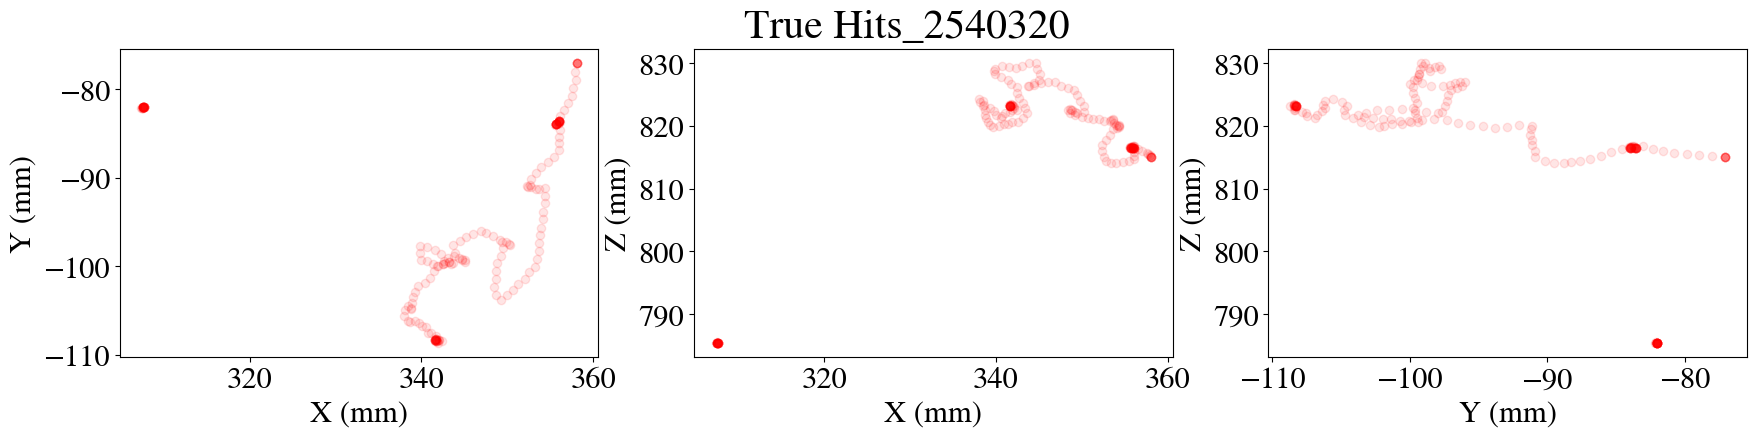

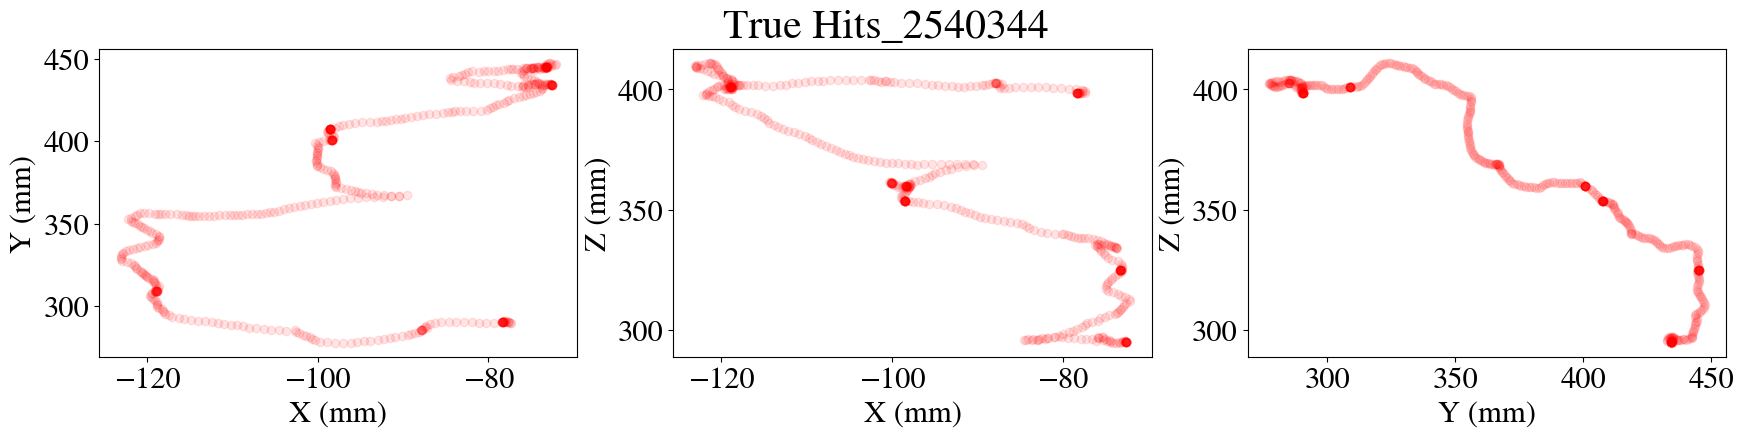

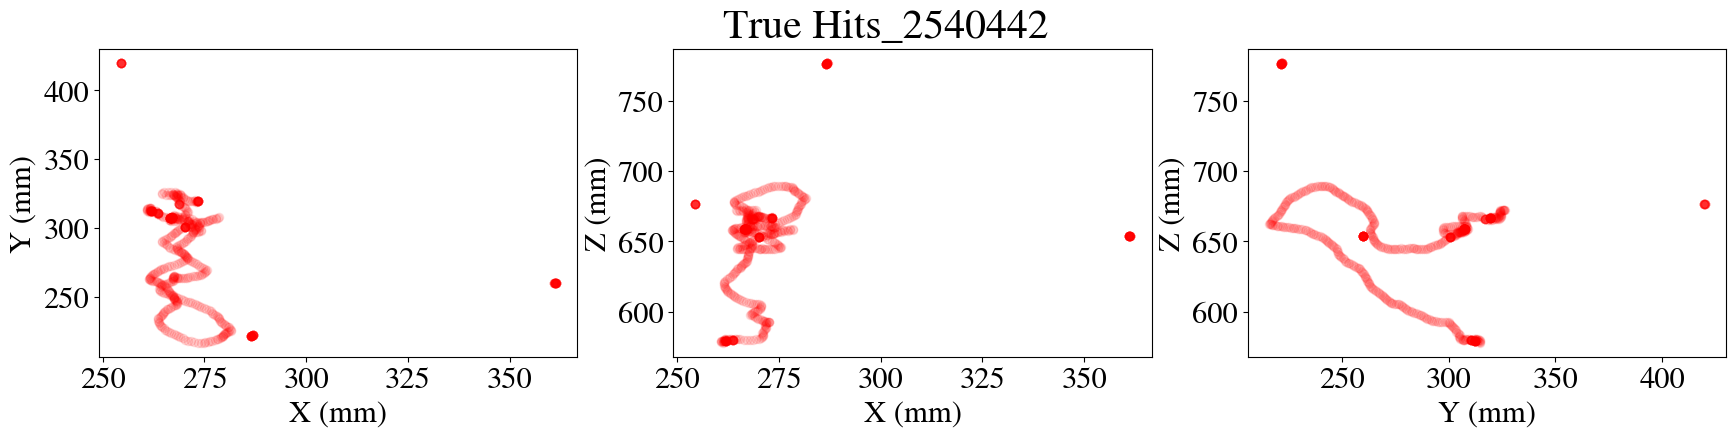

In [11]:
# Load in monte carlo for these events
for i in range(len(sig_evt_id)):

    evtmap = mcio.load_eventnumbermap(file_1).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(file_1).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)
    
    this_evt_true_info = true_info[true_info.event_id == sig_evt_id[i]]

    xt = this_evt_true_info.x
    yt = this_evt_true_info.y
    zt = this_evt_true_info.z
    et = this_evt_true_info.energy*1000

    fig, axes = plt.subplots(1, 3, figsize=(21, 4))
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');

    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    
    fig.suptitle('True Hits_' + str(sig_evt_id[i]), fontsize=30)
    #fig.savefig(pre_dir_name + "/MC_hits")

### looking at the MC quickly, cause of these weird dots in the events

In [12]:
#print(checking_track.columns)

In [13]:
display(df_ps[df_ps['event_id'] == 1270003])

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
232,1270003,1,Tl208,True,0,397.771271,397.154510,537.291504,0.000000,397.771271,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,none,RadioactiveDecay
233,1270003,4,e-,False,1,397.771271,397.154510,537.291504,0.001305,394.458740,...,-0.710335,-0.486962,-0.503382,-0.000000,0.000000,-0.00000,0.609814,5.075905e+00,RadioactiveDecay,eIoni
234,1270003,3,anti_nu_e,False,1,397.771271,397.154510,537.291504,0.001305,12500.000000,...,1.077389,-0.296696,0.412950,1.077389,-0.296696,0.41295,1.191353,1.338238e+04,RadioactiveDecay,Transportation
235,1270003,2,Pb208[3197.711],False,1,397.771271,397.154510,537.291504,0.001305,397.771271,...,-0.367053,0.783657,0.090432,-0.000000,0.000000,0.00000,0.000002,0.000000e+00,RadioactiveDecay,RadioactiveDecay
236,1270003,6,gamma,False,2,397.771271,397.154510,537.291504,0.001305,407.790131,...,0.227716,-0.445658,-0.299404,0.000000,0.000000,0.00000,0.583188,3.089474e+01,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,1270003,142,e-,False,136,347.174133,374.977844,533.835754,0.193354,347.174133,...,-0.030356,-0.006096,-0.001097,-0.000000,-0.000000,-0.00000,0.000938,1.463988e-05,phot,eIoni
370,1270003,141,e-,False,136,347.174133,374.977844,533.835754,0.193354,347.174133,...,0.009427,-0.005101,0.002344,0.000000,-0.000000,0.00000,0.000118,2.055104e-07,phot,msc
371,1270003,140,e-,False,136,347.174133,374.977844,533.835754,0.193354,347.174103,...,-0.052836,-0.062955,0.019098,-0.000000,-0.000000,-0.00000,0.006920,2.816402e-04,phot,eIoni
372,1270003,135,e-,False,134,347.184540,374.961273,533.827942,0.193284,347.177765,...,0.066671,-0.145126,0.363727,0.000000,-0.000000,-0.00000,0.136244,4.553174e-02,phot,eIoni


In [14]:
checking_track = df_ps[df_ps['event_id'] == 1270003]
display(checking_track[checking_track['particle_name'] == 'e+'])
posi_id = checking_track[checking_track['particle_name'] == 'e+'].particle_id.to_numpy()
#display(checking_track[checking_track['initial_x'] < -140])

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
258,1270003,30,e+,False,26,241.919312,307.031525,558.922424,0.613344,252.619385,...,-0.632811,-0.978452,-0.384404,-0.0,-0.0,0.0,0.818175,235.562592,conv,annihil


In [15]:
print("=============")
print("Initial event")
print("=============")
display(checking_track[checking_track['particle_id'] == posi_id[0]])
children_posi = checking_track[checking_track['mother_id'] == posi_id[0]]
print("=============")
print("Children of positron")
print("=============")
display(children_posi)
anihillation_gamma_ids = children_posi[children_posi['creator_proc'] == 'annihil'].particle_id.to_numpy()
for i in range(len(anihillation_gamma_ids)):
    print("=============")
    print("Children of gamma-ID: {}".format(anihillation_gamma_ids[i]))
    print("=============")
    display(checking_track[checking_track['mother_id'] == anihillation_gamma_ids[i]])



Initial event


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
258,1270003,30,e+,False,26,241.919312,307.031525,558.922424,0.613344,252.619385,...,-0.632811,-0.978452,-0.384404,-0.0,-0.0,0.0,0.818175,235.562592,conv,annihil


Children of positron


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
259,1270003,49,gamma,False,30,252.619385,185.266098,577.463013,1.511606,357.810669,...,0.090007,-0.256632,0.432618,-0.0,-0.0,0.0,0.510999,1075.065308,annihil,phot
281,1270003,48,gamma,False,30,252.619385,185.266098,577.463013,1.511606,510.825165,...,-0.090007,0.256632,-0.432618,-0.0,-0.0,0.0,0.510999,1066.626831,annihil,phot
329,1270003,47,e-,False,30,252.623566,185.232819,577.477600,1.510493,252.159088,...,-0.140553,-0.129838,0.015011,-0.0,0.0,-0.0,0.034857,1.834125,eIoni,eIoni
330,1270003,46,e-,False,30,252.614578,185.234207,577.376038,1.509603,252.614624,...,0.001751,-0.004897,0.002625,-0.0,0.0,-0.0,0.000033,0.000140,eIoni,msc
331,1270003,45,e-,False,30,252.614578,185.234207,577.376038,1.509603,252.614700,...,0.002568,-0.003546,-0.001358,0.0,-0.0,-0.0,0.000021,0.000310,eIoni,eIoni
332,1270003,44,e-,False,30,252.614578,185.234207,577.376038,1.509603,252.614487,...,-0.002345,-0.003740,0.001236,0.0,0.0,-0.0,0.000021,0.000188,eIoni,msc
333,1270003,43,e-,False,30,252.614578,185.234207,577.376038,1.509603,252.614609,...,0.001450,-0.006331,0.002166,0.0,0.0,-0.0,0.000046,0.000156,eIoni,msc
334,1270003,42,e-,False,30,252.614578,185.234207,577.376038,1.509603,252.614578,...,-0.000410,-0.002164,-0.004020,0.0,0.0,-0.0,0.000021,0.000073,eIoni,msc
335,1270003,41,e-,False,30,252.614578,185.234207,577.376038,1.509603,252.614532,...,-0.001303,-0.006524,-0.001092,-0.0,-0.0,-0.0,0.000044,0.000456,eIoni,eIoni
336,1270003,40,e-,False,30,252.614578,185.234207,577.376038,1.509603,252.614594,...,0.000504,-0.002898,-0.002010,0.0,-0.0,0.0,0.000012,0.000146,eIoni,msc


Children of gamma-ID: 49


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
260,1270003,70,e-,False,49,357.810669,-304.153595,1476.815796,5.097638,357.810669,...,0.004710,-0.000165,-0.006086,0.0,-0.0,-0.0,0.000058,1.447787e-07,phot,msc
261,1270003,69,e-,False,49,357.810669,-304.153595,1476.815796,5.097638,357.810669,...,-0.005725,-0.000431,-0.005156,-0.0,-0.0,-0.0,0.000058,1.450558e-07,phot,msc
262,1270003,68,e-,False,49,357.810669,-304.153595,1476.815796,5.097638,357.810669,...,0.001190,0.000222,0.005708,0.0,0.0,0.0,0.000033,1.218642e-07,phot,msc
263,1270003,67,e-,False,49,357.810669,-304.153595,1476.815796,5.097638,357.810669,...,-0.000504,0.007854,0.000011,-0.0,0.0,0.0,0.000061,1.473075e-07,phot,msc
264,1270003,66,e-,False,49,357.810669,-304.153595,1476.815796,5.097638,357.810669,...,-0.003470,0.003113,0.003551,-0.0,0.0,0.0,0.000034,1.221262e-07,phot,msc
265,1270003,65,e-,False,49,357.810669,-304.153595,1476.815796,5.097638,357.810669,...,-0.024121,-0.015280,0.003036,-0.0,-0.0,0.0,0.000806,1.365643e-05,phot,eIoni
266,1270003,64,e-,False,49,357.810669,-304.153595,1476.815796,5.097638,357.810669,...,-0.006908,0.003632,-0.029046,-0.0,-0.0,-0.0,0.000884,1.045623e-05,phot,eIoni
267,1270003,63,e-,False,49,357.810669,-304.153595,1476.815796,5.097638,357.810638,...,-0.015413,0.069298,-0.045606,-0.0,0.0,-0.0,0.006920,2.892444e-04,phot,eIoni
268,1270003,62,e-,False,49,357.810669,-304.153595,1476.815796,5.097638,357.805908,...,-0.294170,-0.164541,0.013892,0.0,-0.0,0.0,0.101310,2.725172e-02,phot,eIoni
269,1270003,61,e-,False,49,358.978455,-302.182892,1475.545288,5.088901,358.978607,...,0.104518,-0.034193,-0.024619,0.0,-0.0,0.0,0.012278,7.228898e-04,compt,eIoni


Children of gamma-ID: 48


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
282,1270003,91,e-,False,48,510.825165,-259.136200,95.961365,5.069490,510.825165,...,0.005221,0.001577,-0.005431,0.0,0.0,-0.0,0.000058,1.447787e-07,phot,msc
283,1270003,90,e-,False,48,510.825165,-259.136200,95.961365,5.069490,510.825165,...,-0.004047,0.001572,-0.006591,-0.0,0.0,-0.0,0.000061,1.476343e-07,phot,msc
284,1270003,89,e-,False,48,510.825165,-259.136200,95.961365,5.069490,510.825165,...,-0.004349,-0.005004,-0.003948,0.0,-0.0,-0.0,0.000058,1.450558e-07,phot,msc
285,1270003,88,e-,False,48,510.825165,-259.136200,95.961365,5.069490,510.825165,...,0.022891,0.017474,-0.010454,0.0,0.0,-0.0,0.000918,1.585068e-05,phot,eIoni
286,1270003,87,e-,False,48,510.825165,-259.136200,95.961365,5.069490,510.825165,...,-0.001357,0.028154,-0.002250,-0.0,0.0,-0.0,0.000782,1.286286e-05,phot,eIoni
287,1270003,86,e-,False,48,510.825165,-259.136200,95.961365,5.069490,510.825165,...,-0.005460,-0.004832,-0.004376,-0.0,-0.0,-0.0,0.000071,1.571542e-07,phot,msc
288,1270003,85,e-,False,48,510.825165,-259.136200,95.961365,5.069490,510.825165,...,0.038429,0.074384,0.010490,0.0,0.0,0.0,0.006920,2.780227e-04,phot,eIoni
289,1270003,84,e-,False,48,510.825165,-259.136200,95.961365,5.069490,510.827148,...,-0.188838,-0.065193,-0.254859,-0.0,-0.0,0.0,0.093966,2.537613e-02,phot,eIoni
290,1270003,83,e-,False,48,511.515778,-258.799652,95.525635,5.066544,511.517883,...,0.220374,0.103671,-0.025693,0.0,0.0,0.0,0.055651,9.133794e-03,compt,eIoni
291,1270003,82,e-,False,48,500.956940,-263.725952,93.763657,5.027237,500.955475,...,-0.026849,-0.252058,-0.078805,0.0,-0.0,-0.0,0.064835,1.236313e-02,compt,eIoni


In [16]:
pd.set_option('display.max_columns', None)

double_escape_IDs = []

for i in range(len(signal_id)):
    # select specific event
    signal_data = pos_df[pos_df['event_id'] == signal_id[i]]
    #display(signal_data)
    df_ps_data = df_ps[df_ps['event_id'] == signal_id[i]]
    mother_id_pos = signal_data.particle_id.to_numpy()[0]
    positron_children = df_ps_data[df_ps_data['mother_id'] == mother_id_pos]
    #display(positron_children)
    # collect the annihilation gammas
    annihilation_gamma_id = positron_children[positron_children['creator_proc'] == 'annihil'].particle_id.to_numpy()
    #display(annihilation_gamma_id)
    for j in range(len(annihilation_gamma_id)):
        # check the two gammas children, they better not exist
        gamma_children = (df_ps_data[df_ps_data['mother_id'] == annihilation_gamma_id[j]])
        #display(gamma_children)
        # check that no events occur from the children within ACTIVE
        gamma_active = gamma_children[gamma_children['final_volume'] == 'ACTIVE']
        if len(gamma_active.index) == 0:
            double_escape_IDs.append(signal_id[i])
        else:
            #print("Event {} not double-photo, remove...".format(signal_id[i]))
            # kill it
            if (j == 0):
                break
            elif (j == 1):
                # remove previous double_escape_ID event from list
                double_escape_IDs.remove(signal_id[i])



double_escape_IDs = np.unique(np.array(double_escape_IDs))
    
    

In [17]:
print("{}/{} events with double photo-escape".format(len(double_escape_IDs), len(signal_id)))
print("")
print("{:.2f}% of events within file are signal events\n      within our energy region".format((len(double_escape_IDs)/len(event_list))*100))

30/53 events with double photo-escape

8.85% of events within file are signal events
      within our energy region


In [5]:
# lets try reading in all the data and collecting the number of events

X = func.numb_of_signal_events('../FOM_merge&fit/12_12_18/PORT_1a/isaura/')
np.save('port_1a_signal_evts', X[0])
X = func.numb_of_signal_events('../FOM_merge&fit/12_12_18/PORT_1b/isaura/')
np.save('port_1b_signal_evts', X[0])
X = func.numb_of_signal_events('../FOM_merge&fit/12_12_18/PORT_2a/isaura/')
np.save('port_2a_signal_evts', X[0])
X = func.numb_of_signal_events('../FOM_merge&fit/12_12_18/PORT_2b/isaura/')
np.save('port_2b_signal_evts', X[0])

100%|██████████| 300/300 [03:08<00:00,  1.59it/s]


6940/100009 events with double photo-escape

6.94% of events within file are signal events
      within our energy region


100%|██████████| 300/300 [03:08<00:00,  1.59it/s]


6611/95550 events with double photo-escape

6.92% of events within file are signal events
      within our energy region


100%|██████████| 300/300 [02:27<00:00,  2.03it/s]


5284/71042 events with double photo-escape

7.44% of events within file are signal events
      within our energy region


100%|██████████| 300/300 [03:06<00:00,  1.61it/s]

6800/95440 events with double photo-escape

7.12% of events within file are signal events
      within our energy region


### load in isaura data to compare how many events are left after reconstruction

In [3]:
data = func.load_data('../FOM_merge&fit/12_12_18/PORT_2b/isaura/')

50
100
150
200
250
300


In [4]:
X = np.load('port_2b_signal_evts.npy')
# eqyuivalent to MC
X = np.multiply(X[0], 2)

ValueError: Object arrays cannot be loaded when allow_pickle=False

In [13]:
display(data[0])
print(X)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,0.471529,40.271305,26,4789,5,-10.325,277.675,611.079066,...,624.120421,5.889444,313.781531,617.368591,0.227538,0.198317,0.022022,10.900000,11.090909,9.241821
1,5080000,1,0.000317,18.089486,2,15,5,-54.325,301.675,617.039259,...,617.039259,-53.828408,302.181002,623.081222,0.000232,0.000085,0.000000,10.900000,11.090909,9.241821
2,5080000,2,0.000125,0.000000,1,6,5,4.675,363.675,617.039259,...,617.039259,5.845175,364.846948,617.039259,0.000125,0.000125,0.000125,10.900000,11.090909,9.241821
3,5080000,3,0.000061,0.000000,1,3,5,53.675,255.675,620.036813,...,620.036813,54.335225,256.355619,620.036813,0.000061,0.000061,0.000061,10.900000,11.090909,9.241821
4,5080000,4,0.000020,0.000000,1,1,5,-35.325,243.675,623.081222,...,623.081222,-35.325000,243.675000,623.081222,0.000020,0.000020,0.000020,10.900000,11.090909,9.241821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249948,4060652,0,0.322800,31.781242,10,3060,5,-86.325,151.675,144.115470,...,161.811461,-69.623494,179.784998,151.705489,0.252175,0.133525,0.063827,11.807692,11.741935,11.148056
249949,4060652,1,0.067347,16.652166,3,827,5,-15.325,198.675,236.099571,...,240.611338,-1.297586,213.157391,239.364273,0.066975,0.064542,0.064170,11.807692,11.741935,11.148056
249950,4060652,2,0.026308,0.000000,1,245,5,149.675,-130.325,229.572427,...,230.287347,158.264274,-124.491782,230.287347,0.026308,0.026308,0.026308,11.807692,11.741935,11.148056
249951,4060652,3,0.000760,0.000000,1,13,5,-98.325,119.675,155.985227,...,155.985227,-97.367502,121.871728,155.985227,0.000760,0.000760,0.000760,11.807692,11.741935,11.148056


[5080008 5080038 5080052 ... 4060594 4060596 4060650]


In [34]:
display(data[0][data[0].event == 0])

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
212804,0,0,0.422379,68.345659,51,7367,2,-304.325,220.675,1078.080281,...,1094.701310,-244.723493,275.570623,1085.246748,0.163437,0.053367,0.000000,11.090909,11.428571,10.630375
212805,0,1,0.025505,11.090909,2,501,2,-349.325,220.675,1135.810594,...,1137.966554,-333.793206,224.048032,1139.776352,0.025505,0.025505,0.025505,11.090909,11.428571,10.630375


In [49]:
# how many events are retained in isaura pre-cuts?
isaura_evts = np.unique(data[0].event.to_numpy())
sig_evts_pre_cuts = isaura_evts[np.isin(isaura_evts, X)]
sig_evts_dead_pre_cuts = X[np.logical_not(np.isin(X, sig_evts_pre_cuts))]
#print(sig_evts_pre_cuts)
#print(len(sig_evts_pre_cuts))
print("{}/{} events retained in isaura post processing".format(len(sig_evts_pre_cuts), len(X)))

6050/6800 events retained in isaura post processing


In [56]:
# the events that we lost:
print(len(sig_evts_dead_pre_cuts))
#np.save('port_2b_isaura_lost_evts.npy', sig_evts_dead_pre_cuts)
print(sig_evts_dead_pre_cuts)

750
[5080204 5080350 5080610 1740016 1740208 1740478 3580118 3580626 1140100
 3260046 3260088 3260538   80290   20080   20548   20600   20608 3900012
 3900162 3900448 1560082 1560160 1560386 1560536 3840050 3840182 3840246
 3840278 3840366 3840532 2720124 2720172 2720284 2720416 5800014 5800064
 5800108 5800262 5800390 2020544 2020596 2020602  240138  240234  240248
  240590  420126  420160  420280 5160054 5160100 5160380 1460636 3560150
 3560316 2520114 4140330 4140518 4140550  940022  940068  940122  940510
  940618 2820328 2700158 1920074 1920272 1920314 1920368 4800532 5260252
 5260432 2260010 2260280 2260348 2140020 2140506 5020422 5020470 4820158
 4820440 4820448 4820594 1900320 1900478 1900488 1900606 5340270 5340552
 4920004 4920012 4920492 1360392 3300186 3300206 2800224 2800474 2800544
 5480132 5480234 5480448 4620266 4620280 4620450 5040376 5040382 5040540
  980104  980278 1580094 1580480 3700144 3700480 3700672 3760214 3760248
 3760320 3760344  960170 3640010 3640054 364017

In [2]:
# functionalise, apply to all ports

def isaura_pre_cuts_loss(MC_signal_list, isaura_data):
    '''
    creates arrays of all the IDs of
    events that are retained post isaura

    pass through the paths, it will do the rest
    MAKE SURE THE PATHS ARE OF THE EQUIVALENT PORTS
    otherwise your result will be empty
    '''
    
    # MC LOAD
    X = np.load(MC_signal_list)
    X = np.multiply(X, 2)

    # DATA LOAD
    data = func.load_data(isaura_data)


        # how many events are retained in isaura pre-cuts?
    isaura_evts = np.unique(data[0].event.to_numpy())
    sig_evts_pre_cuts = isaura_evts[np.isin(isaura_evts, X)]
    sig_evts_dead_pre_cuts = X[np.logical_not(np.isin(X, sig_evts_pre_cuts))]
    #print(sig_evts_pre_cuts)
    #print(len(sig_evts_pre_cuts))
    print("{}/{} events retained in isaura post processing".format(len(sig_evts_pre_cuts), len(X)))

    return (sig_evts_pre_cuts, sig_evts_dead_pre_cuts)

In [3]:
Q1a = isaura_pre_cuts_loss('port_1a_signal_evts.npy', '../FOM_merge&fit/12_12_18/PORT_1a/isaura/')
Q1b = isaura_pre_cuts_loss('port_1b_signal_evts.npy', '../FOM_merge&fit/12_12_18/PORT_1b/isaura/')
Q2a = isaura_pre_cuts_loss('port_2a_signal_evts.npy', '../FOM_merge&fit/12_12_18/PORT_2a/isaura/')

50
100
150
200
250
300
6348/6940 events retained in isaura post processing
50
100
150
200
250
300
6137/6611 events retained in isaura post processing
50
100
150
200
250
300
4803/5284 events retained in isaura post processing


### So we now have a nice signal event dataframe with all the signal events from isaura, you also have a nice 'sigs that died in beer-isau' dataframe you can look at 

In [48]:
data_sig_evts = data[0][data[0].event.isin(sig_evts_pre_cuts)]
display(data[0][data[0].event.isin(sig_evts_pre_cuts)])

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
9,5080008,0,1.566657,211.962619,78,5692,1,-82.325,147.675,1107.440644,...,1116.733538,-21.062626,156.144972,1188.176603,0.443501,0.370949,0.000000,11.428571,10.714286,10.968530
52,5080038,0,0.301892,32.658744,10,3133,7,274.675,351.675,1079.248734,...,1086.462008,288.839891,379.968160,1092.164049,0.230536,0.121924,0.060169,11.866667,11.986486,11.951928
53,5080038,1,0.175083,16.866939,4,1116,7,24.675,-440.325,132.400423,...,135.849678,32.714125,-433.436801,134.704294,0.174870,0.174763,0.174550,11.866667,11.986486,11.951928
54,5080038,2,0.002423,0.000000,1,25,7,86.675,-445.325,132.400423,...,132.400423,88.226419,-443.826783,132.400423,0.002423,0.002423,0.002423,11.866667,11.986486,11.951928
55,5080038,3,0.001450,11.866667,2,60,7,34.675,-390.325,134.888726,...,134.888726,38.906807,-385.590756,134.888726,0.001450,0.001450,0.001450,11.866667,11.986486,11.951928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249943,4060650,2,0.000371,0.000000,1,22,7,390.675,60.675,522.266030,...,522.266030,392.405587,62.603159,522.266030,0.000371,0.000371,0.000371,11.615385,12.000000,11.718301
249944,4060650,3,0.000360,16.700813,2,11,7,301.675,99.675,519.295317,...,519.295317,304.483939,101.285120,519.295317,0.000360,0.000360,0.000360,11.615385,12.000000,11.718301
249945,4060650,4,0.000277,0.000000,1,11,7,337.675,139.675,516.230072,...,517.732329,343.661420,141.860998,517.732329,0.000277,0.000277,0.000277,11.615385,12.000000,11.718301
249946,4060650,5,0.000163,0.000000,1,10,7,392.675,144.675,522.266030,...,522.266030,394.191827,145.703739,522.266030,0.000163,0.000163,0.000163,11.615385,12.000000,11.718301


In [4]:
np.save('port_1a_isaura_lost_evts.npy', Q1a[1])
np.save('port_1b_isaura_lost_evts.npy', Q1b[1])
np.save('port_2a_isaura_lost_evts.npy', Q2a[1])


### load in MC for each port, and look at where these dead events occur

In [6]:
p1a_MC = func.positron_scraper('../FOM_merge&fit/12_12_18/PORT_1a/isaura/')

In [15]:
display(p1a_MC[p1a_MC.event_id.isin(np.divide(Q1a[1],2))])
p1a_dead_events = p1a_MC[p1a_MC.event_id.isin(np.divide(Q1a[1],2))]

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
18034,2540230,33,e+,False,31,-120.011719,184.369354,1170.306885,2.831968,-36.498264,...,-0.964789,-0.070357,1.105450,-0.0,-0.0,0.0,1.044285,262.666321,conv,annihil
24738,2540317,29,e+,False,27,-108.722130,302.885529,712.251770,1.814575,-168.772247,...,-1.170005,-0.582173,0.360615,-0.0,0.0,0.0,0.937794,224.848572,conv,annihil
26666,2540342,49,e+,False,47,82.290222,71.964165,527.905579,1.499842,97.344032,...,-0.720335,-1.019894,-0.034983,0.0,-0.0,-0.0,0.838597,246.759216,conv,annihil
31294,870022,104,e+,False,101,474.255981,378.687897,663.260254,0.501075,474.411255,...,0.801442,0.005667,1.080345,-0.0,-0.0,0.0,0.927961,0.637852,conv,annihil
41211,870142,43,e+,False,41,787.701965,840.147705,545.356140,1.981765,787.808777,...,0.672199,1.581025,-0.543675,0.0,0.0,0.0,1.362019,1.017445,conv,annihil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729170,880268,64,e+,False,61,368.887817,285.587006,304.009796,0.866161,365.971680,...,0.104832,-0.279229,-1.397984,-0.0,-0.0,0.0,1.007039,163.278015,conv,annihil
776520,2470201,48,e+,False,46,-113.884239,63.992214,293.064240,2.179380,-133.018188,...,-0.606497,-0.437092,-0.270593,-0.0,-0.0,0.0,0.434108,98.031509,conv,annihil
776891,2470207,49,e+,False,47,-138.792999,-465.593811,1566.740479,4.832397,-138.837341,...,-0.262014,-0.483464,0.945533,-0.0,0.0,-0.0,0.696288,0.497300,conv,annihil
793585,2030076,31,e+,False,29,265.779724,227.315796,493.617126,0.728851,244.709610,...,-0.769162,-0.556854,-0.432540,0.0,-0.0,0.0,0.650857,124.893456,conv,annihil


In [41]:
print(p1a_dead_events.columns)
dead_momentum = np.sqrt(np.square(p1a_dead_events.initial_momentum_x.to_numpy()) + np.square(p1a_dead_events.initial_momentum_y.to_numpy()) + np.square(p1a_dead_events.initial_momentum_z.to_numpy()))

Index(['event_id', 'particle_id', 'particle_name', 'primary', 'mother_id',
       'initial_x', 'initial_y', 'initial_z', 'initial_t', 'final_x',
       'final_y', 'final_z', 'final_t', 'initial_volume', 'final_volume',
       'initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
       'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
       'kin_energy', 'length', 'creator_proc', 'final_proc'],
      dtype='object')


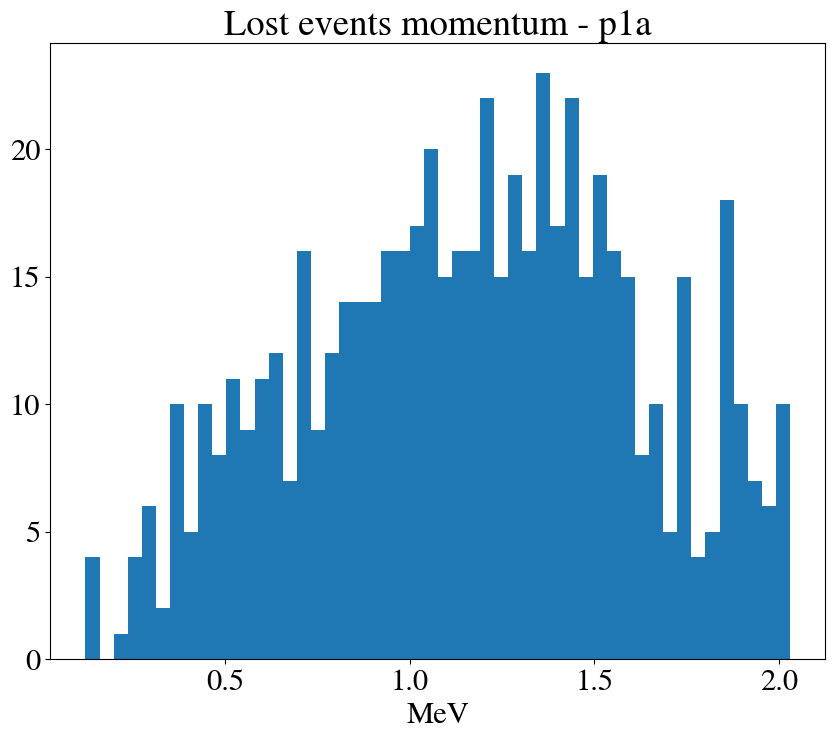

In [50]:
plt.hist(dead_momentum, bins = 50)
plt.title("Lost events momentum - p1a")
plt.xlabel("MeV")
plt.show()

#### initially, lets look at position, I think that will tell us a lot

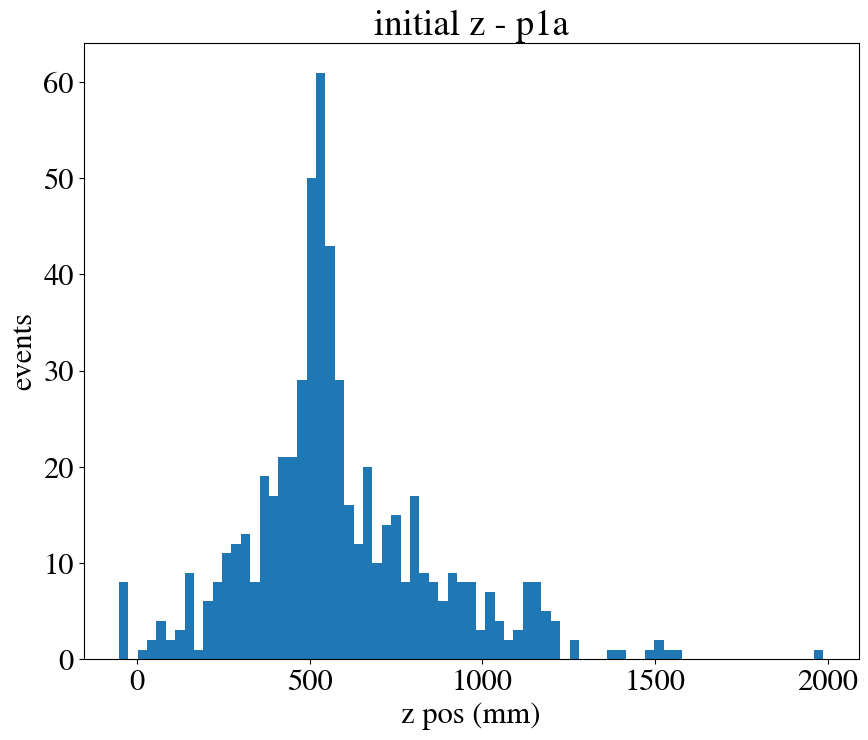

In [25]:
func.plot_hist(p1a_dead_events, column = 'initial_z', title = 'initial z - p1a', x_label = 'z pos (mm)', log = False, binning = 75)

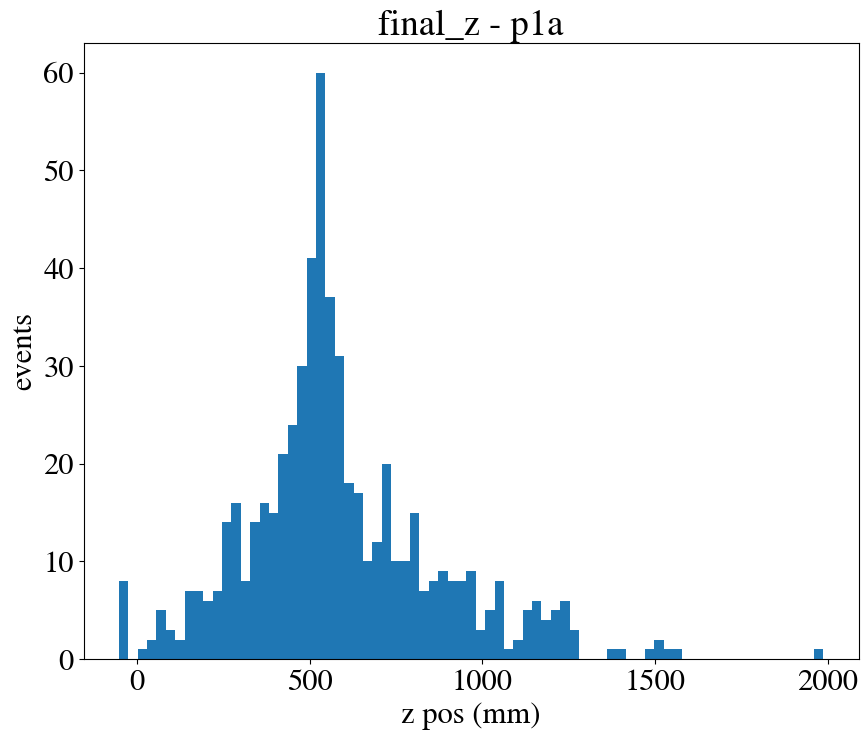

In [27]:
func.plot_hist(p1a_dead_events, column = 'final_z', title = 'final_z - p1a', x_label = 'z pos (mm)', log = False, binning = 75)

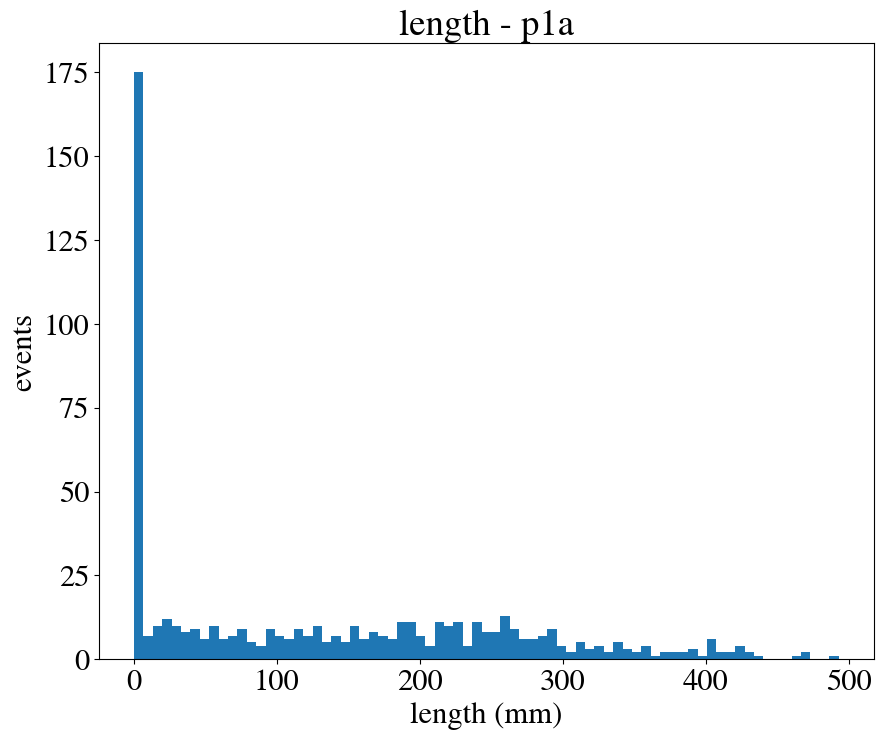

In [35]:
func.plot_hist(p1a_dead_events, column = 'length', title = 'length - p1a', x_label = 'length (mm)', log = False, binning = 75)

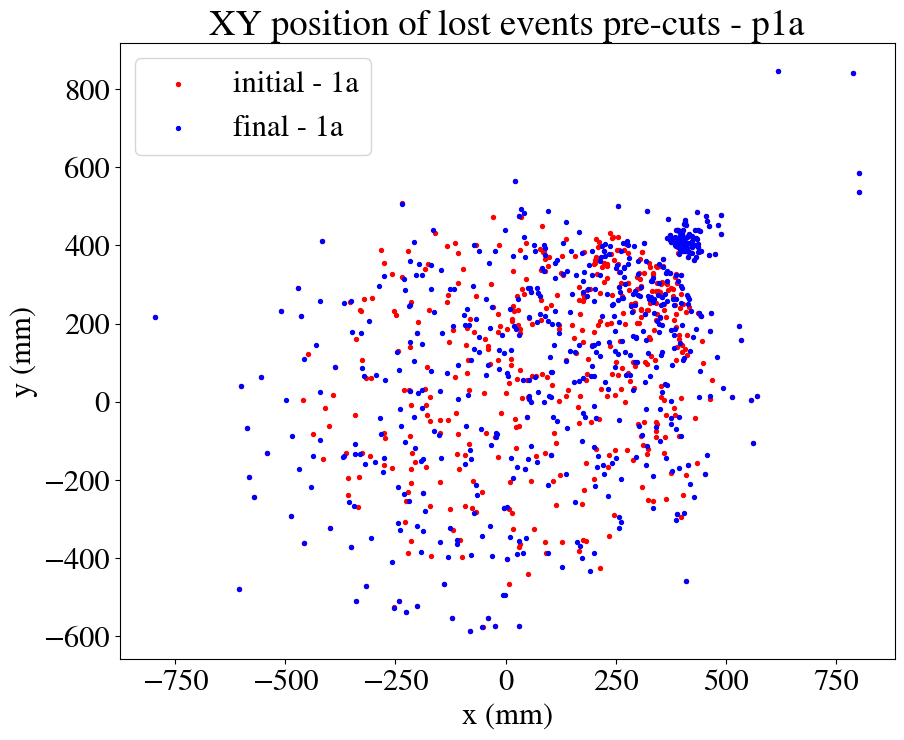

In [31]:
size = 8

plt.Figure(figsize=(10,10))
plt.scatter(p1a_dead_events.initial_x, p1a_dead_events.initial_y, label = 'initial - 1a', s = size, color = 'red')
plt.scatter(p1a_dead_events.final_x, p1a_dead_events.final_y, label = 'final - 1a', s = size, color = 'blue')
plt.legend()
plt.title("XY position of lost events pre-cuts - p1a")
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

In [32]:
p1a_alive_events = p1a_MC[p1a_MC.event_id.isin(np.divide(Q1a[0],2))]

In [39]:
display(p1a_alive_events)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
1182,2540016,32,e+,False,30,-166.862320,-370.026581,1148.358154,3.770954,-198.535721,...,-0.247377,-0.461457,1.173200,0.0,0.0,-0.0,0.871628,187.018860,conv,annihil
1375,2540018,37,e+,False,35,-65.955795,324.198029,272.437469,1.781441,-22.099428,...,-1.258216,-0.110806,-0.581811,0.0,-0.0,0.0,0.970557,263.940033,conv,annihil
1757,2540024,18,e+,False,16,394.422913,407.527100,535.740845,0.035130,394.485077,...,0.217861,0.929769,-0.199142,0.0,-0.0,0.0,0.590233,0.248721,conv,annihil
2494,2540033,40,e+,False,38,427.781158,377.352051,442.963135,0.340736,428.130005,...,0.537648,-0.716717,-1.240047,-0.0,0.0,-0.0,1.101944,0.871644,conv,annihil
3008,2540040,46,e+,False,38,426.655273,364.533203,592.671570,0.232653,426.677277,...,0.462149,-0.210924,0.238228,-0.0,0.0,-0.0,0.247910,0.071758,conv,annihil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809509,2030281,50,e+,False,48,400.105957,406.193726,522.728760,0.061671,400.066101,...,-0.195851,0.441247,-0.557106,0.0,0.0,-0.0,0.385964,0.259034,conv,annihil
811340,2030303,39,e+,False,37,136.485687,54.518787,504.019226,1.433447,82.499695,...,-0.430029,-0.882541,-0.276713,-0.0,-0.0,-0.0,0.629831,140.283585,conv,annihil
811463,2030304,38,e+,False,36,177.461746,373.692688,428.131470,0.812318,178.767731,...,-0.777295,0.036702,-0.102590,0.0,0.0,0.0,0.425579,101.616592,conv,annihil
812092,2030312,29,e+,False,27,397.566254,407.091736,551.510803,0.072451,397.579163,...,-0.019162,0.906891,1.363706,0.0,0.0,-0.0,1.204703,0.740120,conv,annihil


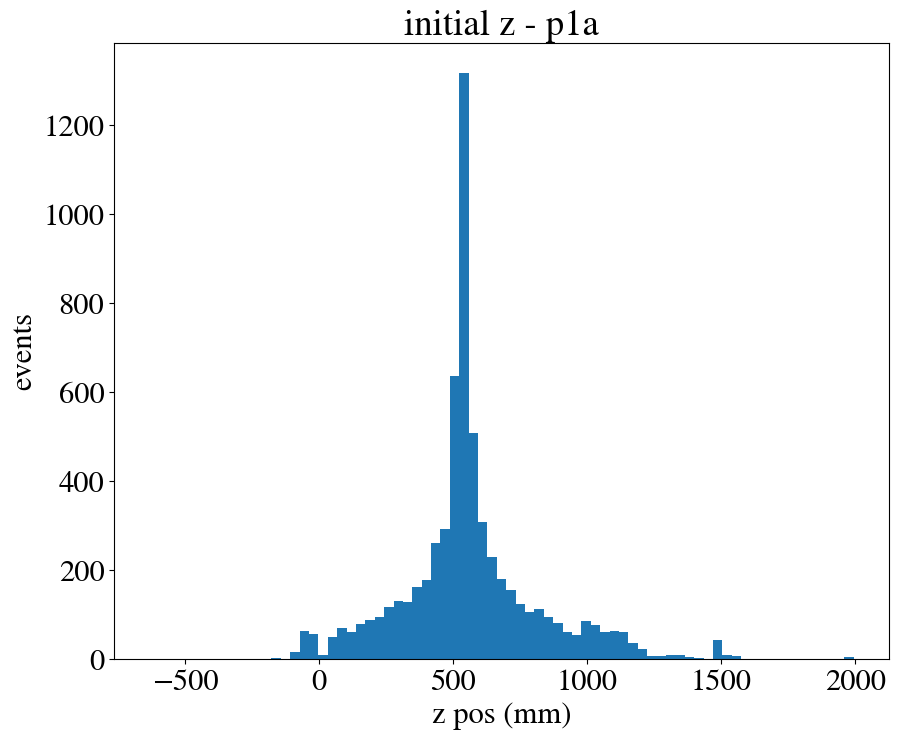

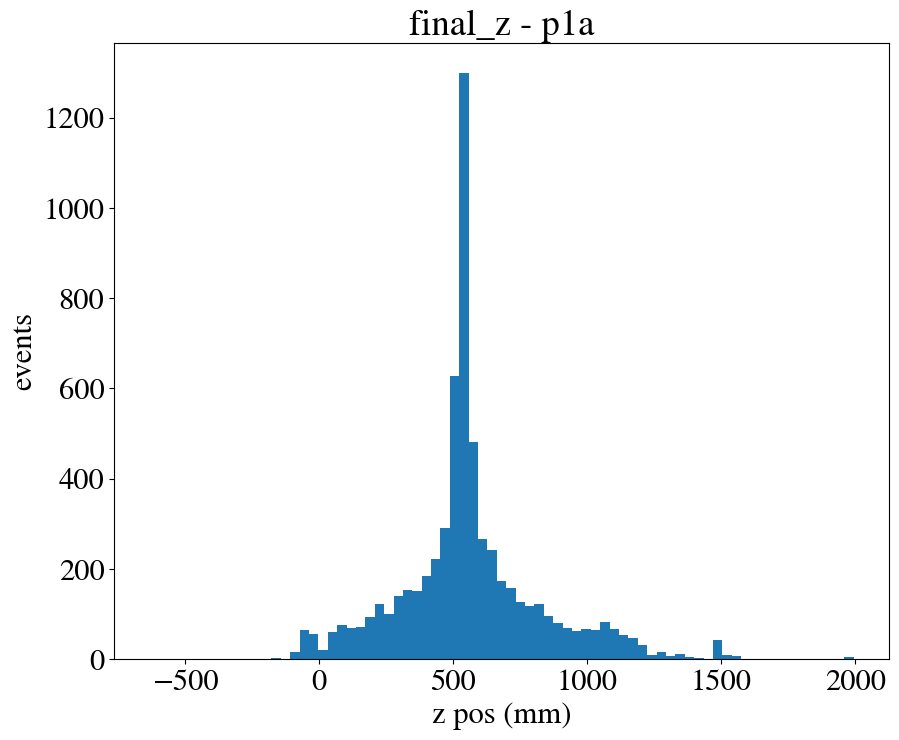

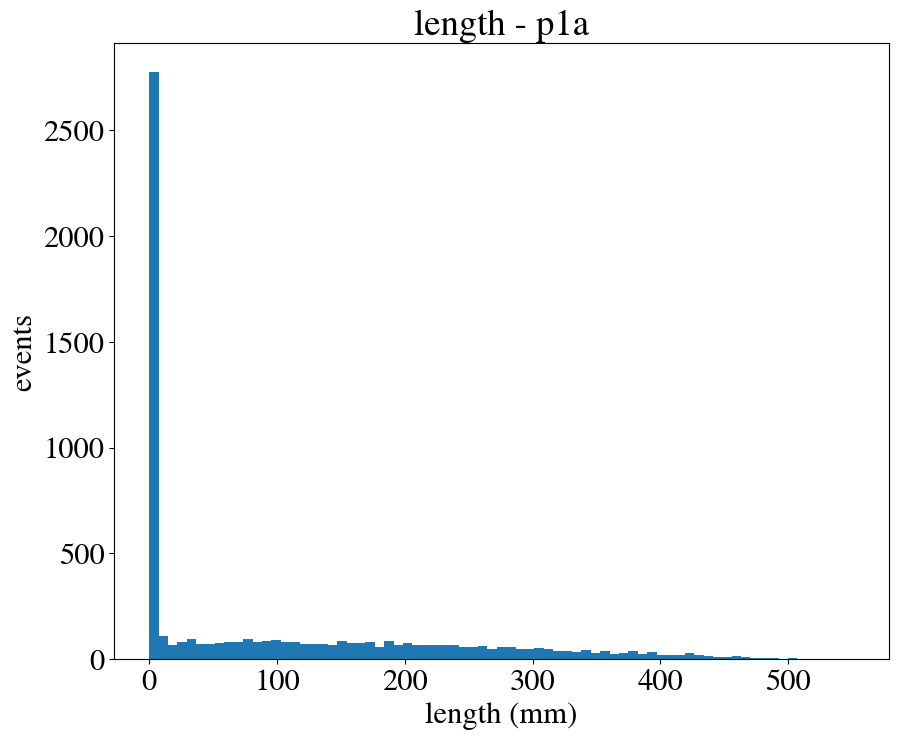

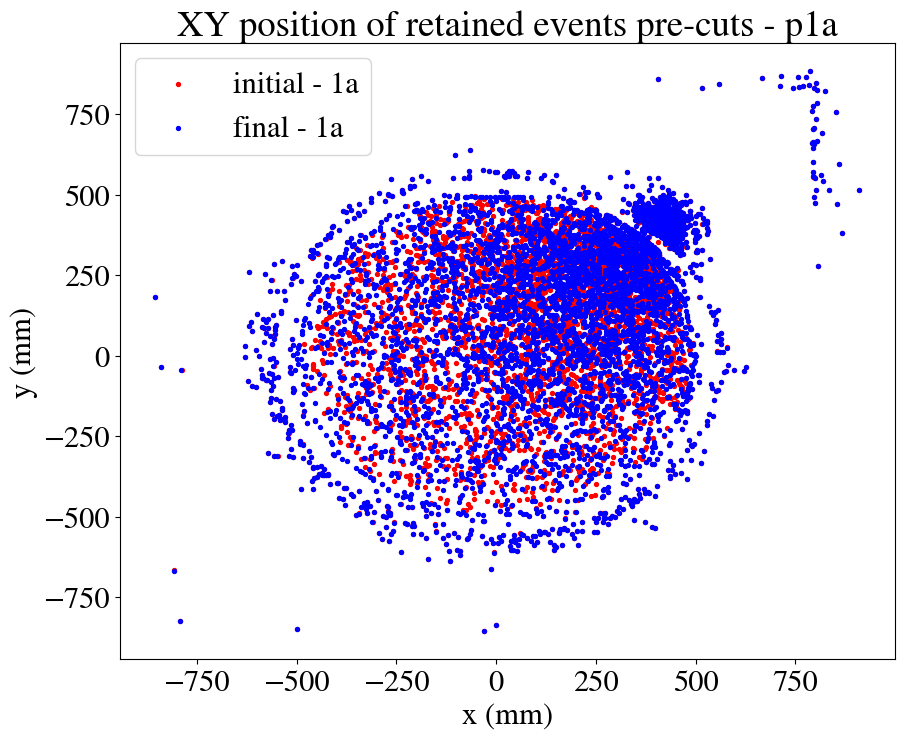

In [37]:
func.plot_hist(p1a_alive_events, column = 'initial_z', title = 'initial z - p1a', x_label = 'z pos (mm)', log = False, binning = 75, output = True)
func.plot_hist(p1a_alive_events, column = 'final_z', title = 'final_z - p1a', x_label = 'z pos (mm)', log = False, binning = 75, output = True)
func.plot_hist(p1a_alive_events, column = 'length', title = 'length - p1a', x_label = 'length (mm)', log = False, binning = 75, output = True)

size = 8

plt.Figure(figsize=(10,10))
plt.scatter(p1a_alive_events.initial_x, p1a_alive_events.initial_y, label = 'initial - 1a', s = size, color = 'red')
plt.scatter(p1a_alive_events.final_x, p1a_alive_events.final_y, label = 'final - 1a', s = size, color = 'blue')
plt.legend()
plt.title("XY position of retained events pre-cuts - p1a")
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

In [46]:
alive_momentum = np.sqrt(np.square(p1a_alive_events.initial_momentum_x.to_numpy()) + np.square(p1a_alive_events.initial_momentum_y.to_numpy()) + np.square(p1a_alive_events.initial_momentum_z.to_numpy()))

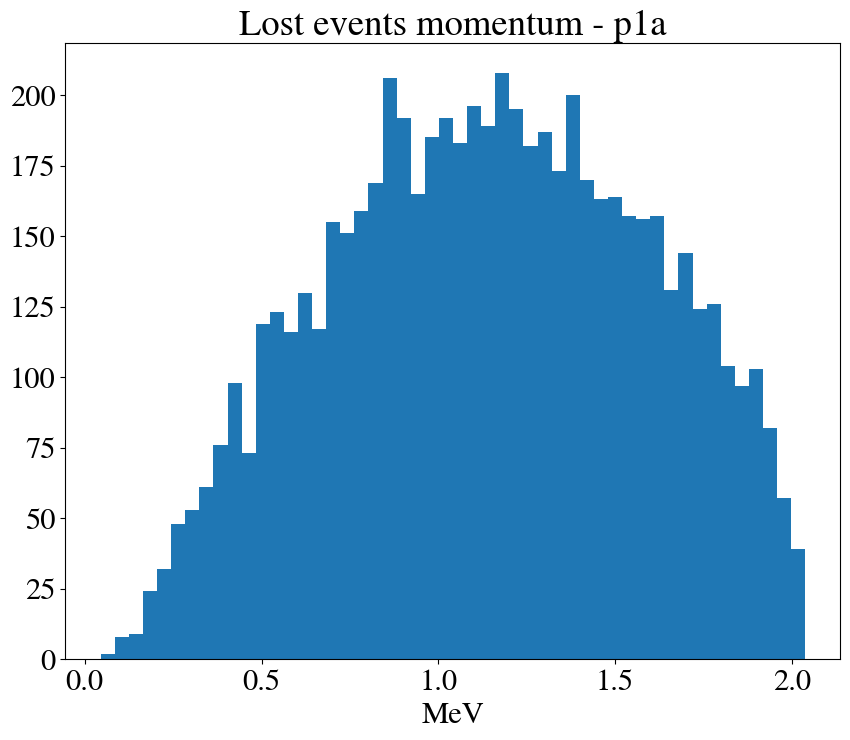

In [49]:
plt.hist(alive_momentum, bins = 50)
plt.title("Lost events momentum - p1a")
plt.xlabel("MeV")
plt.show()

### Where do the events go? Which cut kills them? Lets check

In [52]:
data = func.load_data('../FOM_merge&fit/12_12_18/PORT_1a/isaura/')

50


100
150
200
250
300


In [60]:
signal_events_pre_cuts = data[0][data[0].event.isin(np.multiply(p1a_alive_events.event_id.to_numpy(),2))]
display(data[0])
print(np.multiply(p1a_alive_events.event_id.to_numpy(),2))
display(signal_events_pre_cuts)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
0,5080000,0,1.068732,168.887195,64,9158,1,375.675,161.675,330.900281,...,351.363116,384.212773,278.679478,445.580642,0.381491,0.039862,0.000000,12.200000,14.000,13.534216
1,5080002,0,1.282228,248.187363,42,4241,4,-79.325,344.675,515.180105,...,652.083986,94.850390,364.689594,517.833734,0.232929,0.072599,0.000000,14.444444,14.125,14.263647
2,5080002,1,0.654868,69.761558,18,2150,4,-100.325,415.675,603.385913,...,649.876075,-89.159408,425.914687,608.759268,0.301268,0.081590,0.000000,14.444444,14.125,14.263647
3,5080002,2,0.147971,14.444444,2,457,4,133.675,360.675,499.470366,...,502.128486,141.302478,368.127983,500.803068,0.144027,0.136373,0.132430,14.444444,14.125,14.263647
4,5080002,3,0.023711,14.125000,2,79,4,30.675,411.675,618.959316,...,620.857981,34.008329,416.683574,620.686133,0.023711,0.023711,0.023711,14.444444,14.125,14.263647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251826,4060710,0,0.568012,71.474342,32,7496,1,302.675,276.675,522.659780,...,529.652476,337.047409,282.508143,524.696333,0.087141,0.021570,0.000000,14.500000,13.000,14.432458
251827,4060712,0,0.895780,100.681739,42,6285,4,11.675,412.675,332.916150,...,343.974535,19.441606,473.057348,414.524553,0.375787,0.055782,0.000000,13.000000,14.375,12.914461
251828,4060712,1,0.000598,0.000000,1,12,4,-3.325,364.675,351.397889,...,351.397889,-1.832545,365.692154,351.397889,0.000598,0.000598,0.000598,13.000000,14.375,12.914461
251829,4060712,2,0.000392,0.000000,1,9,4,72.675,411.675,357.396638,...,357.396638,73.668721,412.679487,357.396638,0.000392,0.000392,0.000392,13.000000,14.375,12.914461


[5080032 5080036 5080048 ... 4060608 4060624 4060712]


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
33,5080032,0,1.598716,74.158324,33,6217,2,-215.325,-417.325,1142.037881,...,1158.593888,-145.096068,-398.166215,1148.191537,0.141627,0.067286,0.000000,13.555556,14.571429,14.618313
34,5080032,1,0.071890,19.901749,3,1318,2,-120.325,-447.325,1065.600375,...,1074.861677,-102.958261,-434.795525,1074.539771,0.068272,0.061105,0.060180,13.555556,14.571429,14.618313
43,5080036,0,1.598448,151.586004,47,7013,1,-94.325,310.675,261.474757,...,273.612099,-21.554582,405.959477,282.694657,0.595636,0.354803,0.000000,13.833333,13.250000,11.554614
50,5080048,0,0.400162,34.933112,6,3038,1,255.675,-28.325,248.998739,...,254.173859,266.005215,-5.609549,256.835609,0.237837,0.106927,0.003459,14.571429,14.222222,14.372958
80,5080066,0,0.634920,60.598912,23,5874,3,-12.325,208.675,442.110802,...,486.127574,25.818918,219.153029,449.114016,0.282482,0.096946,0.000000,13.875000,14.166667,13.084313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251708,4060624,3,0.000056,0.000000,1,8,4,410.675,144.675,580.042969,...,580.042969,412.178870,146.190722,580.042969,0.000056,0.000056,0.000056,14.857143,13.555556,13.652242
251827,4060712,0,0.895780,100.681739,42,6285,4,11.675,412.675,332.916150,...,343.974535,19.441606,473.057348,414.524553,0.375787,0.055782,0.000000,13.000000,14.375000,12.914461
251828,4060712,1,0.000598,0.000000,1,12,4,-3.325,364.675,351.397889,...,351.397889,-1.832545,365.692154,351.397889,0.000598,0.000598,0.000598,13.000000,14.375000,12.914461
251829,4060712,2,0.000392,0.000000,1,9,4,72.675,411.675,357.396638,...,357.396638,73.668721,412.679487,357.396638,0.000392,0.000392,0.000392,13.000000,14.375000,12.914461


In [76]:
print(len(np.unique(signal_events_pre_cuts['event'].to_numpy())))

signal_events_cut_tracks = signal_events_pre_cuts[signal_events_pre_cuts.energy > 0.05]

6348


In [79]:
l = func.apply_cuts(signal_events_cut_tracks, upper_z = 1170, r_lim = 415, lower_z = 20)
r = func.apply_cuts(signal_events_pre_cuts, upper_z = 1170, r_lim = 415, lower_z = 20)

Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 51.91 %
Absolute Cut efficiency:
Efficiency: 51.91 %
One track cut
Relative Cut efficiency:
Efficiency: 80.58 %
Absolute Cut efficiency:
Efficiency: 76.37 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 93.37 %
Absolute Cut efficiency:
Efficiency: 86.48 %
Energy cut
Relative Cut efficiency:
Efficiency: 51.84 %
Absolute Cut efficiency:
Efficiency: 33.13 %
Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 49.20 %
Absolute Cut efficiency:
Efficiency: 49.20 %
One track cut
Relative Cut efficiency:
Efficiency: 50.66 %
Absolute Cut efficiency:
Efficiency: 45.64 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 98.48 %
Absolute Cut efficiency:
Efficiency: 87.93 %
Energy cut
Relative Cut efficiency:
Efficiency: 72.91 %
Absolute 

In [80]:
display(l[0])
display(l[1])
display(r[0])
display(r[1])

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
227,5080188,0,1.596666,142.574971,52,7896,1,158.675,108.675,732.606853,...,785.027008,245.271906,184.840218,738.766280,0.401743,0.147500,0.0,13.428571,14.285714,13.750328
623,5080496,0,1.594726,155.914133,55,8261,1,143.675,-164.325,324.260803,...,348.161171,152.706628,-122.940969,334.020871,0.363796,0.277997,0.0,13.857143,13.142857,13.214012
642,5080512,0,1.597181,97.208768,42,8501,1,200.675,202.675,573.029888,...,580.108874,246.698125,211.390214,621.227128,0.316163,0.253213,0.0,13.750000,13.166667,13.990134
737,5080582,0,1.597251,142.007874,59,6551,1,296.675,-46.325,681.238031,...,725.763938,337.279082,56.812115,714.750819,0.317242,0.209471,0.0,14.142857,14.500000,13.223831
842,5080668,0,1.593205,111.234895,38,8731,1,-47.325,146.675,665.352253,...,742.245496,-38.196326,157.740231,677.733722,0.311266,0.071116,0.0,13.200000,14.750000,14.077350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251394,4060350,0,1.594231,180.619138,70,8061,1,50.675,26.675,412.437638,...,540.469649,158.243684,69.459342,443.782566,0.376754,0.375581,0.0,14.750000,13.500000,14.974961
251537,4060472,0,1.595414,110.581396,68,8067,1,82.675,85.675,180.581346,...,190.647199,91.478782,95.387479,218.631079,0.319784,0.297252,0.0,12.666667,13.666667,13.460095
251565,4060498,0,1.591080,151.022833,60,8103,1,14.675,-227.325,487.036988,...,491.836409,38.011982,-217.016944,536.263755,0.379389,0.171688,0.0,13.166667,14.285714,13.392281
251626,4060546,0,1.539007,365.954238,83,8009,3,204.675,78.675,411.519675,...,454.924749,253.834228,209.415876,598.963243,0.365967,0.057958,0.0,14.388889,14.333333,14.111039


,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,6348,100.000000
1,Fiducial Cuts,51.906112,3295,51.906112
2,One track cut,80.576631,2655,76.370510
3,Blob overlap cuts,93.370998,2479,86.483932
4,Energy cuts,51.835418,1285,33.128544


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
227,5080188,0,1.596666,142.574971,52,7896,1,158.675,108.675,732.606853,...,785.027008,245.271906,184.840218,738.766280,0.401743,0.147500,0.0,13.428571,14.285714,13.750328
623,5080496,0,1.594726,155.914133,55,8261,1,143.675,-164.325,324.260803,...,348.161171,152.706628,-122.940969,334.020871,0.363796,0.277997,0.0,13.857143,13.142857,13.214012
642,5080512,0,1.597181,97.208768,42,8501,1,200.675,202.675,573.029888,...,580.108874,246.698125,211.390214,621.227128,0.316163,0.253213,0.0,13.750000,13.166667,13.990134
737,5080582,0,1.597251,142.007874,59,6551,1,296.675,-46.325,681.238031,...,725.763938,337.279082,56.812115,714.750819,0.317242,0.209471,0.0,14.142857,14.500000,13.223831
842,5080668,0,1.593205,111.234895,38,8731,1,-47.325,146.675,665.352253,...,742.245496,-38.196326,157.740231,677.733722,0.311266,0.071116,0.0,13.200000,14.750000,14.077350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250869,4940584,0,1.599061,112.454083,47,6944,1,294.675,23.675,840.843084,...,907.677769,365.033741,91.008115,847.376766,0.402216,0.209468,0.0,13.000000,15.000000,14.973131
251394,4060350,0,1.594231,180.619138,70,8061,1,50.675,26.675,412.437638,...,540.469649,158.243684,69.459342,443.782566,0.376754,0.375581,0.0,14.750000,13.500000,14.974961
251537,4060472,0,1.595414,110.581396,68,8067,1,82.675,85.675,180.581346,...,190.647199,91.478782,95.387479,218.631079,0.319784,0.297252,0.0,12.666667,13.666667,13.460095
251565,4060498,0,1.591080,151.022833,60,8103,1,14.675,-227.325,487.036988,...,491.836409,38.011982,-217.016944,536.263755,0.379389,0.171688,0.0,13.166667,14.285714,13.392281


,Cut,Relative Efficiency,Relative Events,Single Cut Efficiency
0,No cuts,100.000000,6348,100.000000
1,Fiducial Cuts,49.196597,3123,49.196597
2,One track cut,50.656420,1582,45.636421
3,Blob overlap cuts,98.482933,1558,87.933207
4,Energy cuts,72.913992,1136,33.128544


In [85]:
# update the number of tracks for events with satellites removed
# count the number of events identified with unique event, and change numb_of_tracks to reflect this
event_counts = signal_events_cut_tracks['event'].value_counts(sort = False)

# apply this to numb_of_tracks
signal_events_cut_tracks['numb_of_tracks'] = signal_events_cut_tracks['event'].map(event_counts)

display(signal_events_cut_tracks[signal_events_cut_tracks['numb_of_tracks'] > 1])

two_tracks_signal = signal_events_cut_tracks[signal_events_cut_tracks['numb_of_tracks'] > 1]

/tmp/ipykernel_13709/13510626.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal_events_cut_tracks['numb_of_tracks'] = signal_events_cut_tracks['event'].map(event_counts)


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
33,5080032,0,1.598716,74.158324,33,6217,2,-215.325,-417.325,1142.037881,...,1158.593888,-145.096068,-398.166215,1148.191537,0.141627,0.067286,0.000000,13.555556,14.571429,14.618313
34,5080032,1,0.071890,19.901749,3,1318,2,-120.325,-447.325,1065.600375,...,1074.861677,-102.958261,-434.795525,1074.539771,0.068272,0.061105,0.060180,13.555556,14.571429,14.618313
210,5080172,0,0.379733,25.043756,7,2671,2,-135.325,134.675,179.387611,...,191.658006,-116.703655,152.468955,185.296420,0.340661,0.319270,0.288838,14.894737,14.562500,13.902162
211,5080172,1,0.324058,20.830737,4,1916,2,29.675,396.675,157.680354,...,162.110004,39.083368,406.716654,161.913833,0.309108,0.298075,0.283514,14.894737,14.562500,13.902162
370,5080304,0,0.364936,25.526347,8,3374,2,260.675,145.675,437.798091,...,454.555485,271.917534,153.345357,446.072304,0.266955,0.221878,0.136083,15.000000,14.384615,14.821513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251479,4060420,1,0.073836,13.142857,2,1039,2,121.675,-103.325,850.254234,...,854.608077,129.778715,-94.825741,855.914070,0.073827,0.073433,0.073423,12.833333,13.142857,13.088381
251512,4060440,0,0.366252,39.192196,14,5342,2,141.675,147.675,801.000638,...,805.896825,174.825498,180.454613,812.073732,0.176467,0.131297,0.007254,14.000000,14.588235,14.019212
251513,4060440,1,0.088058,20.219214,3,1559,2,113.675,336.675,654.051431,...,660.155373,131.172989,348.059760,657.845700,0.080698,0.073978,0.069412,14.000000,14.588235,14.019212
251705,4060624,0,0.394912,40.666667,11,4119,2,72.675,212.675,503.994291,...,510.379621,89.494642,220.916118,514.672346,0.117079,0.087466,0.000000,14.857143,13.555556,13.652242


In [89]:
# do fiducial cuts first

fiducial_two_track_signals = func.fiducial_track_cut_2(two_tracks_signal, lower_z = 20, upper_z = 1170, r_lim = 415)
display(fiducial_two_track_signals)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
387,5080316,0,0.396866,46.215798,16,4080,2,-123.325,-105.325,289.954022,...,296.843398,-91.546659,-95.670076,309.330900,0.162704,0.076481,0.000000,15.000000,15.000000,13.233659
388,5080316,1,0.156441,21.213203,4,2038,2,-184.325,45.675,384.045638,...,390.489564,-175.135195,56.626383,390.129610,0.145573,0.142762,0.133830,15.000000,15.000000,13.233659
482,5080386,0,0.306748,35.617261,7,2833,2,-57.325,-75.325,370.611084,...,378.922306,-26.966855,-67.178524,377.689739,0.174965,0.166085,0.047553,14.769231,14.714286,14.411170
483,5080386,1,0.117148,20.848031,3,1703,2,-179.325,41.675,618.276750,...,622.758639,-168.097172,60.260559,622.633191,0.108688,0.081973,0.073728,14.769231,14.714286,14.411170
628,5080500,0,0.796571,52.431316,14,2652,3,-33.325,186.675,833.479106,...,842.380338,-25.767031,199.357940,850.890834,0.406561,0.120993,0.000000,14.333333,14.333333,12.404421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250890,4940596,1,0.584940,36.654072,10,1997,2,-219.325,29.675,594.940369,...,598.067138,-202.464568,53.723221,603.131512,0.415759,0.358976,0.221863,14.100000,13.500000,12.451950
251478,4060420,0,0.505632,40.924396,16,5798,2,121.675,-156.325,888.046884,...,906.123676,129.057843,-126.932022,897.585351,0.185390,0.135059,0.000000,12.833333,13.142857,13.088381
251479,4060420,1,0.073836,13.142857,2,1039,2,121.675,-103.325,850.254234,...,854.608077,129.778715,-94.825741,855.914070,0.073827,0.073433,0.073423,12.833333,13.142857,13.088381
251512,4060440,0,0.366252,39.192196,14,5342,2,141.675,147.675,801.000638,...,805.896825,174.825498,180.454613,812.073732,0.176467,0.131297,0.007254,14.000000,14.588235,14.019212


In [90]:
print(fiducial_two_track_signals.columns)

Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'r_min',
       'x_max', 'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'r_ave',
       'extreme1_x', 'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y',
       'extreme2_z', 'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y',
       'blob2_z', 'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x',
       'vox_size_y', 'vox_size_z'],
      dtype='object')


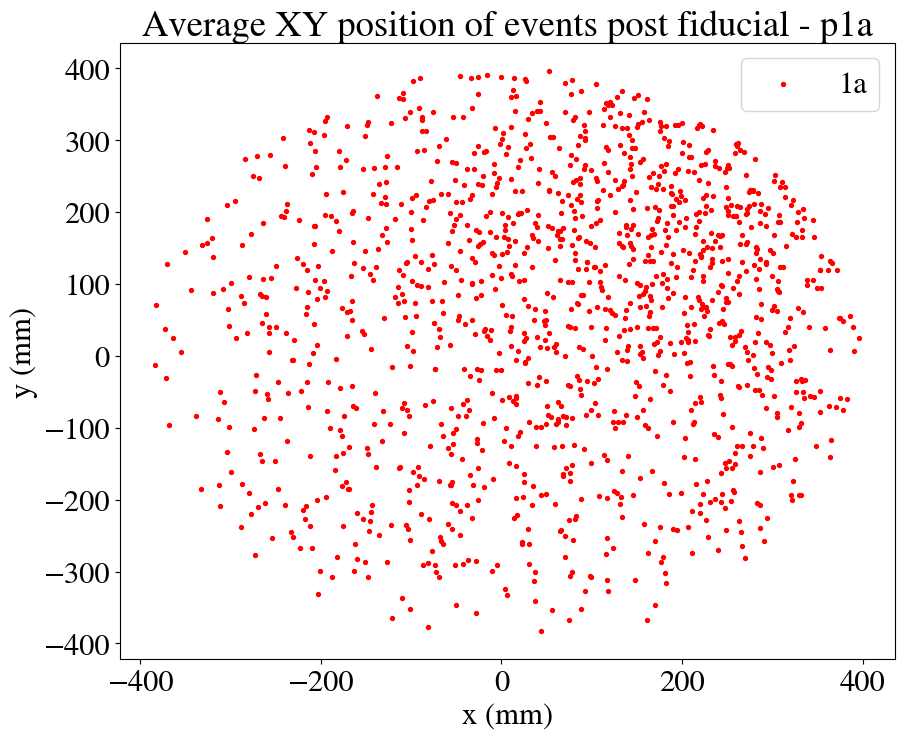

In [91]:
size = 8

plt.Figure(figsize=(10,10))
#plt.scatter(cut_tracks[0][cut_tracks[0].PORT=='1a'].x_ave, cut_tracks[0][cut_tracks[0].PORT=='1a'].y_ave, label = '1a', s = size)
plt.scatter(fiducial_two_track_signals.x_ave, fiducial_two_track_signals.y_ave, label = '1a', s = size, color = 'red')
#plt.scatter(cut_tracks[0][cut_tracks[0].PORT=='2a'].x_ave, cut_tracks[0][cut_tracks[0].PORT=='2a'].y_ave, label = '2a', s = size, color = 'green')
#plt.scatter(cut_tracks[0][cut_tracks[0].PORT=='2b'].x_ave, cut_tracks[0][cut_tracks[0].PORT=='2b'].y_ave, label = '2b', s = size, color = 'black')
plt.legend()
plt.title("Average XY position of events post fiducial - p1a")
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

In [96]:
np.save('p1a_two_tracks_signals.npy', np.unique(fiducial_two_track_signals.event.to_numpy()))

In [110]:
### COLLECT BEERSHEBA PLOTS
file_1 = 'testing_data/beersheba/beersheba_128_208Tl.h5'
#file_2 = 'testing_data/sophronia_129_208Tl.h5'
#file_3 = 'testing_data/sophronia_130_208Tl.h5'

# load in events from deco
hdst = dstio.load_dst(file_1, 'DECO', 'Events')
evtmap = mcio.load_eventnumbermap(file_1).set_index('nexus_evt')
true_info = mcio.load_mchits_df(file_1).reset_index()
true_info.event_id = true_info.event_id.map(evtmap.evt_number)

In [111]:
# one event!
events = hdst[hdst.event.isin(fiducial_two_track_signals.event)]
display(events)


# its one event, so collect like this

this_evt_true_info = true_info[true_info.event_id == events.event.to_numpy()[0]]

xt = this_evt_true_info.x
yt = this_evt_true_info.y
zt = this_evt_true_info.z
et = this_evt_true_info.energy*1000

x = events.X
y = events.Y
z = events.Z
e = events.E*1000

,event,npeak,X,Y,Z,E,Xpeak,Ypeak,time,nsipm,Xrms,Yrms
1279844,2540328,0.0,-216.325,-253.325,1017.213816,0.000186,-192.104269,-247.602669,2.540329e+12,0,0,0
1279845,2540328,0.0,-216.325,-252.325,1017.213816,0.000236,-192.104269,-247.602669,2.540329e+12,0,0,0
1279846,2540328,0.0,-216.325,-251.325,1017.213816,0.000256,-192.104269,-247.602669,2.540329e+12,0,0,0
1279847,2540328,0.0,-216.325,-250.325,1017.213816,0.000239,-192.104269,-247.602669,2.540329e+12,0,0,0
1279848,2540328,0.0,-216.325,-249.325,1017.213816,0.000191,-192.104269,-247.602669,2.540329e+12,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1285718,2540328,0.0,-208.325,-232.325,1079.622731,0.000229,-192.104269,-247.602669,2.540329e+12,0,0,0
1285719,2540328,0.0,-208.325,-231.325,1079.622731,0.000200,-192.104269,-247.602669,2.540329e+12,0,0,0
1285720,2540328,0.0,-207.325,-236.325,1079.622731,0.000184,-192.104269,-247.602669,2.540329e+12,0,0,0
1285721,2540328,0.0,-207.325,-235.325,1079.622731,0.000192,-192.104269,-247.602669,2.540329e+12,0,0,0


In [103]:
#print(x)
x_range = (x.max()-x.min())/2.
y_range = (y.max()-y.min())/2.
z_range = (z.max()-z.min())/2.
mid_x   = (x.max()+x.min())/2.
mid_y   = (y.max()+y.min())/2.
mid_z   = (z.max()+z.min())/2.

xbins = int(x.max()-x.min())
ybins = int(y.max()-y.min())
zbins = int((z.max()-z.min())/2.)


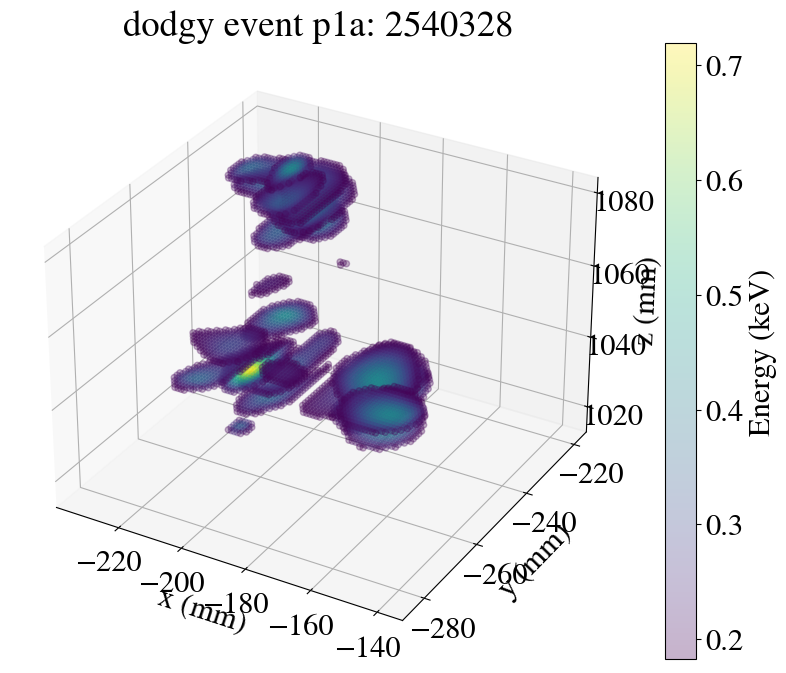

In [106]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title('dodgy event p1a: {}'.format(events.event.to_numpy()[0]))
p = ax.scatter(x, y, z, c=e, alpha=0.3, cmap='viridis')
cb = fig.colorbar(p, ax=ax)
cb.set_label('Energy (keV)')

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

plt.show()


In [107]:
# the event
fiducial_two_track_signals[fiducial_two_track_signals.event == 2540328]

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob1_z,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z
167202,2540328,0,0.953624,65.656999,27,3451,2,-233.325,-265.325,1017.213816,...,1072.049515,-205.124728,-238.539597,1024.550723,0.202978,0.171354,0.0,13.428571,12.8,12.481783
167203,2540328,1,0.636121,40.911543,13,2243,2,-179.325,-283.325,1039.044694,...,1041.068964,-146.910601,-275.827364,1052.926508,0.365994,0.195084,0.0,13.428571,12.8,12.481783


Text(0, 0.5, 'z (mm)')

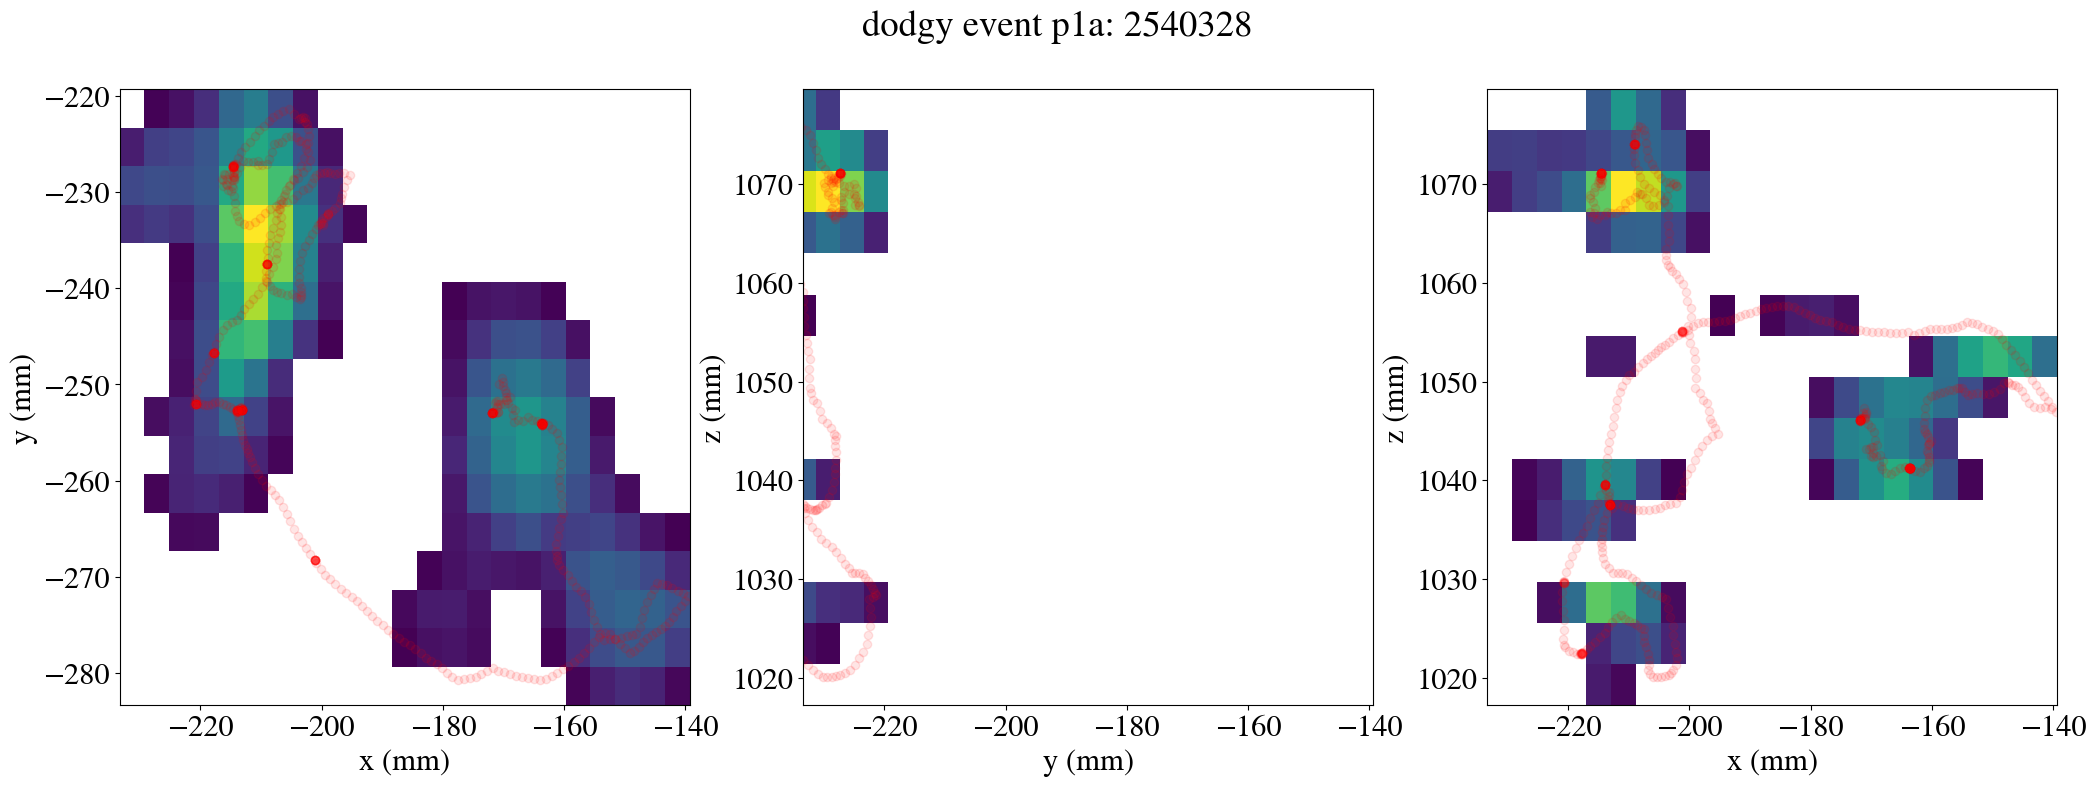

In [113]:
# plot x,y,z
plot_title = "dodgy event p1a: " + str(events.event.to_numpy()[0])
fig, ((ax1), (ax2), (ax3)) = plt.subplots(1, 3, sharex=True, figsize=(25, 8))
fig.suptitle(plot_title)


ax1.hist2d(x, y, weights=e, bins=(int(x_range/2), int(y_range/2)),
               range=((mid_x - x_range, mid_x + x_range), (mid_y - y_range, mid_y + y_range)),
               cmin=0.0001)
# MC
ax1.scatter(xt, yt, color='red', alpha = 0.1)

ax1.set_xlabel('x (mm)')
ax1.set_ylabel('y (mm)')

ax2.hist2d(y, z, weights=e, bins=(int(y_range/2), int(z_range/2)),
               range=((mid_y - y_range, mid_y + y_range), (mid_z - z_range, mid_z + z_range)),
               cmin=0.0001)

# MC
ax2.scatter(yt, zt, color='red', alpha = 0.1)

ax2.set_xlabel('y (mm)')
ax2.set_ylabel('z (mm)')

ax3.hist2d(x, z, weights=e,  bins=(int(x_range/2), int(z_range/2)),
               range=((mid_x - x_range, mid_x + x_range), (mid_z - z_range, mid_z + z_range)),
               cmin=0.0001)

# MC
ax3.scatter(xt, zt, color='red', alpha = 0.1)

ax3.set_xlabel('x (mm)')
ax3.set_ylabel('z (mm)')

cheeky function that scans across collecting images of some of the messy plots

In [127]:
data_path = 'testing_data/beersheba/'
    # collect all filenames
try:
    file_names = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f)) and f.endswith('.h5')]
except:
    print("File path incorrect, please state the correct file path\n(but not any particular folder!)")


for file in file_names:
    file_path = data_path + file

    # load in events from deco
    hdst = dstio.load_dst(file_path, 'DECO', 'Events')
    evtmap = mcio.load_eventnumbermap(file_path).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(file_path).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)

    # collect unique events
    events = hdst[hdst.event.isin(fiducial_two_track_signals.event)]
    
    # list of unique events
    evt_list = np.unique(events.event.to_numpy())
    print("File: {}".format(file))
    print(evt_list)

    pitch = 15.55
    for i in range(len(evt_list)):

        this_evt_true_info = true_info[true_info.event_id == evt_list[i]]

        xt = this_evt_true_info.x
        yt = this_evt_true_info.y
        zt = this_evt_true_info.z
        et = this_evt_true_info.energy*1000

        specific_event = events[events.event == evt_list[i]]


        fig, axes = plt.subplots(1, 3, figsize=(18, 4))

        xx = np.arange(specific_event.X.min(), specific_event.X.max() + pitch, pitch)
        yy = np.arange(specific_event.Y.min(), specific_event.Y.max() + pitch, pitch)
        zz = specific_event.Z.unique()

        axes[0].hist2d(specific_event.X, specific_event.Y, bins=[xx, yy], weights=specific_event.E*1000, cmin=0.0001);
        axes[0].scatter(xt, yt, color='red', alpha = 0.1)
        axes[0].set_xlabel('X (mm)');
        axes[0].set_ylabel('Y (mm)');

        axes[1].hist2d(specific_event.X, specific_event.Z, bins=[xx, zz], weights=specific_event.E*1000, cmin=0.0001);
        axes[1].scatter(xt, zt, color='red', alpha = 0.1)
        axes[1].set_xlabel('X (mm)');
        axes[1].set_ylabel('Z (mm)');


        axes[2].hist2d(specific_event.Y, specific_event.Z, bins=[yy, zz], weights=specific_event.E*1000, cmin=0.0001);
        axes[2].scatter(yt, zt, color='red', alpha = 0.1)
        axes[2].set_xlabel('Y (mm)');
        axes[2].set_ylabel('Z (mm)');


        fig.suptitle("dodgy event p1a: " + str(evt_list[i]), fontsize=30)
        fig.savefig('plots_dodgy_events/' + str(evt_list[i]) + '_2D.png')
        plt.close(fig)
        
        x = specific_event.X
        y = specific_event.Y
        z = specific_event.Z
        e = specific_event.E*1000

        x_range = (x.max()-x.min())/2.
        y_range = (y.max()-y.min())/2.
        z_range = (z.max()-z.min())/2.
        mid_x   = (x.max()+x.min())/2.
        mid_y   = (y.max()+y.min())/2.
        mid_z   = (z.max()+z.min())/2.

        xbins = int(x.max()-x.min())
        ybins = int(y.max()-y.min())
        zbins = int((z.max()-z.min())/2.)

        '''
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        plt.title('dodgy event p1a: {}'.format(evt_list[i]))
        p = ax.scatter(x, y, z, c=e, alpha=0.3, cmap='viridis')
        cb = fig.colorbar(p, ax=ax)
        cb.set_label('Energy (keV)')

        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        ax.set_zlabel('z (mm)')
        plt.savefig('plots_dodgy_events/' + str(evt_list[i]) + '_3D.png')
        plt.close()
        '''
        # plot x,y,z
        plot_title = "dodgy event p1a: " + str(evt_list[i])
        fig, ((ax1), (ax2), (ax3)) = plt.subplots(1, 3, sharex=True, figsize=(25, 8))
        fig.suptitle(plot_title)


        ax1.hist2d(x, y, weights=e, bins=(int(x_range/2), int(y_range/2)),
                    range=((mid_x - x_range, mid_x + x_range), (mid_y - y_range, mid_y + y_range)),
                    cmin=0.0001)
        # MC
        ax1.scatter(xt, yt, color='red', alpha = 0.1)

        ax1.set_xlabel('x (mm)')
        ax1.set_ylabel('y (mm)')

        ax2.hist2d(y, z, weights=e, bins=(int(y_range/2), int(z_range/2)),
                    range=((mid_y - y_range, mid_y + y_range), (mid_z - z_range, mid_z + z_range)),
                    cmin=0.0001)

        # MC
        ax2.scatter(yt, zt, color='red', alpha = 0.1)

        ax2.set_xlabel('y (mm)')
        ax2.set_ylabel('z (mm)')

        ax3.hist2d(x, z, weights=e,  bins=(int(x_range/2), int(z_range/2)),
                    range=((mid_x - x_range, mid_x + x_range), (mid_z - z_range, mid_z + z_range)),
                    cmin=0.0001)

        # MC
        ax3.scatter(xt, zt, color='red', alpha = 0.1)

        ax3.set_xlabel('x (mm)')
        ax3.set_ylabel('z (mm)')

        plt.savefig('plots_dodgy_events/' + str(evt_list[i]) + '_2D_method2.png')
        plt.close(fig)
        

File: beersheba_205_208Tl.h5
[4080148 4080330 4080690 4080710]
File: beersheba_196_208Tl.h5
[3900574 3900646 3900650]
File: beersheba_202_208Tl.h5
[4020492]
File: beersheba_218_208Tl.h5
[4340216 4340462]
File: beersheba_175_208Tl.h5
[3480184]
File: beersheba_27_208Tl.h5
[520050 520470]
File: beersheba_17_208Tl.h5
[320552 320610 320682]
File: beersheba_266_208Tl.h5
[5300372 5300412 5300478]
File: beersheba_106_208Tl.h5
[2100004 2100036]
File: beersheba_203_208Tl.h5
[4040110 4040294]
File: beersheba_51_208Tl.h5
[1000402]
File: beersheba_139_208Tl.h5
[2760048 2760314]
File: beersheba_216_208Tl.h5
[4300418]
File: beersheba_92_208Tl.h5
[1820166 1820646]
File: beersheba_166_208Tl.h5
[3300216 3300256 3300264 3300286 3300482]
File: beersheba_57_208Tl.h5
[1120400 1120674]
File: beersheba_4_208Tl.h5
[60048 60364 60436 60656]
File: beersheba_84_208Tl.h5
[1660382 1660476 1660482 1660600]
File: beersheba_271_208Tl.h5
[]
File: beersheba_296_208Tl.h5
[5900324 5900350]
File: beersheba_81_208Tl.h5
[160

KeyboardInterrupt: 

so about 650 events make it through with two tracks, why? whats up with them. The reconstructed energy is really messed up, need to check what the MC looks like for these events

In [136]:
# lets specifically look at 520470, this is in sophronia_6. lets download it and have a look

FP = 'testing_data/sophronia_27_208Tl.h5'

hdst = dstio.load_dst(FP, 'RECO', 'Events')


evtmap = mcio.load_eventnumbermap(FP).set_index('nexus_evt')
true_info = mcio.load_mchits_df(FP).reset_index()
true_info.event_id = true_info.event_id.map(evtmap.evt_number)


In [137]:
display(hdst)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,520000,5.200012e+11,0,237.823620,-217.509278,1,225.475,-225.475,0.0,0.0,369.512128,5.101449,236.734026,-1.0,0.000766,-1,-1.0
1,520000,5.200012e+11,0,237.823620,-217.509278,1,225.475,-209.925,0.0,0.0,369.512128,10.144928,470.777938,-1.0,0.001512,-1,-1.0
2,520000,5.200012e+11,0,237.823620,-217.509278,1,241.025,-241.025,0.0,0.0,369.512128,4.811594,223.283232,-1.0,0.000741,-1,-1.0
3,520000,5.200012e+11,0,237.823620,-217.509278,1,241.025,-225.475,0.0,0.0,369.512128,13.913044,645.638310,-1.0,0.002115,-1,-1.0
4,520000,5.200012e+11,0,237.823620,-217.509278,1,241.025,-209.925,0.0,0.0,369.512128,18.144928,842.019953,-1.0,0.002748,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147151,520640,5.206420e+11,1,347.356042,323.206374,1,349.875,318.775,0.0,0.0,670.050544,5.913043,188.888896,-1.0,0.000849,-1,-1.0
147152,520640,5.206420e+11,1,347.356042,323.206374,1,349.875,334.325,0.0,0.0,670.050544,5.275362,168.518515,-1.0,0.000608,-1,-1.0
147153,520640,5.206420e+11,1,347.356042,323.206374,1,365.425,318.775,0.0,0.0,670.050544,6.492754,207.407411,-1.0,0.001296,-1,-1.0
147154,520640,5.206420e+11,1,347.356042,323.206374,1,365.425,334.325,0.0,0.0,670.050544,4.521739,144.444446,-1.0,0.000521,-1,-1.0


In [138]:
specific_event = hdst[hdst.event == 520470]
display(specific_event)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
109788,520470,5.204706e+11,0,-15.628242,3.905621,1,-7.775,69.975,0.0,0.0,877.749994,4.173913,339.000000,-1.0,0.001091,-1,-1.0
109789,520470,5.204706e+11,0,-15.628242,3.905621,1,7.775,69.975,0.0,0.0,877.749994,4.173913,339.000000,-1.0,0.001090,-1,-1.0
109790,520470,5.204706e+11,0,-15.628242,3.905621,1,-7.775,69.975,0.0,0.0,880.797553,5.507246,444.063383,-1.0,0.001430,-1,-1.0
109791,520470,5.204706e+11,0,-15.628242,3.905621,1,7.775,54.425,0.0,0.0,880.797553,9.797101,789.965403,-1.0,0.002535,-1,-1.0
109792,520470,5.204706e+11,0,-15.628242,3.905621,1,7.775,69.975,0.0,0.0,880.797553,4.753623,383.296825,-1.0,0.001233,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110679,520470,5.204706e+11,0,-15.628242,3.905621,1,7.775,-23.325,0.0,0.0,974.553628,6.956522,378.855599,-1.0,0.001231,-1,-1.0
110680,520470,5.204706e+11,0,-15.628242,3.905621,1,7.775,-7.775,0.0,0.0,974.553628,5.391304,293.613087,-1.0,0.000957,-1,-1.0
110681,520470,5.204706e+11,0,-15.628242,3.905621,1,7.775,7.775,0.0,0.0,974.553628,6.492754,353.598540,-1.0,0.001153,-1,-1.0
110682,520470,5.204706e+11,0,-15.628242,3.905621,1,-85.525,-101.075,0.0,0.0,977.768400,4.347826,532.361973,-1.0,0.001743,-1,-1.0


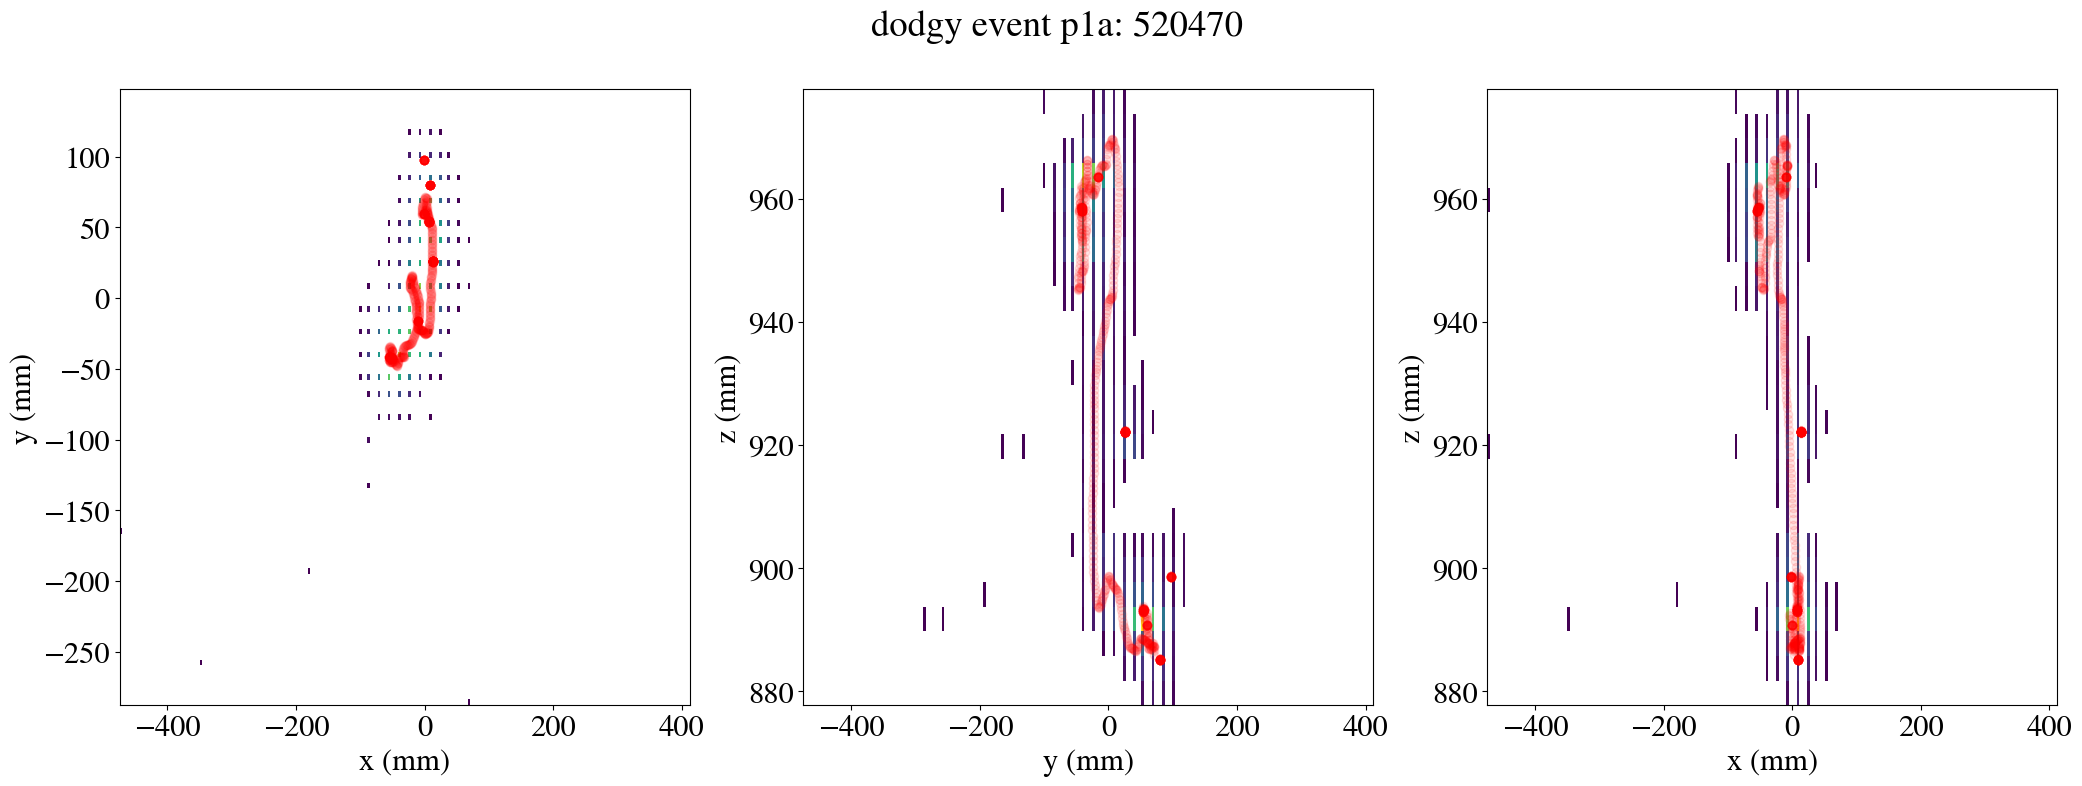

In [139]:
this_evt_true_info = true_info[true_info.event_id == 520470]

xt = this_evt_true_info.x
yt = this_evt_true_info.y
zt = this_evt_true_info.z
et = this_evt_true_info.energy*1000

x = specific_event.X
y = specific_event.Y
z = specific_event.Z
e = specific_event.E*1000

x_range = (x.max()-x.min())/2.
y_range = (y.max()-y.min())/2.
z_range = (z.max()-z.min())/2.
mid_x   = (x.max()+x.min())/2.
mid_y   = (y.max()+y.min())/2.
mid_z   = (z.max()+z.min())/2.

xbins = int(x.max()-x.min())
ybins = int(y.max()-y.min())
zbins = int((z.max()-z.min())/2.)


# plot x,y,z
plot_title = "dodgy event p1a: " + str(520470)
fig, ((ax1), (ax2), (ax3)) = plt.subplots(1, 3, sharex=True, figsize=(25, 8))
fig.suptitle(plot_title)


ax1.hist2d(x, y, weights=e, bins=(int(x_range/2), int(y_range/2)),
            range=((mid_x - x_range, mid_x + x_range), (mid_y - y_range, mid_y + y_range)),
            cmin=0.0001)
# MC
ax1.scatter(xt, yt, color='red', alpha = 0.1)

ax1.set_xlabel('x (mm)')
ax1.set_ylabel('y (mm)')

ax2.hist2d(y, z, weights=e, bins=(int(y_range/2), int(z_range/2)),
            range=((mid_y - y_range, mid_y + y_range), (mid_z - z_range, mid_z + z_range)),
            cmin=0.0001)

# MC
ax2.scatter(yt, zt, color='red', alpha = 0.1)

ax2.set_xlabel('y (mm)')
ax2.set_ylabel('z (mm)')

ax3.hist2d(x, z, weights=e,  bins=(int(x_range/2), int(z_range/2)),
            range=((mid_x - x_range, mid_x + x_range), (mid_z - z_range, mid_z + z_range)),
            cmin=0.0001)

# MC
ax3.scatter(xt, zt, color='red', alpha = 0.1)

ax3.set_xlabel('x (mm)')
ax3.set_ylabel('z (mm)')
plt.show()
#plt.savefig('plots_dodgy_events/' + str(evt_list[i]) + '_2D_method2.png')
#plt.close(fig)

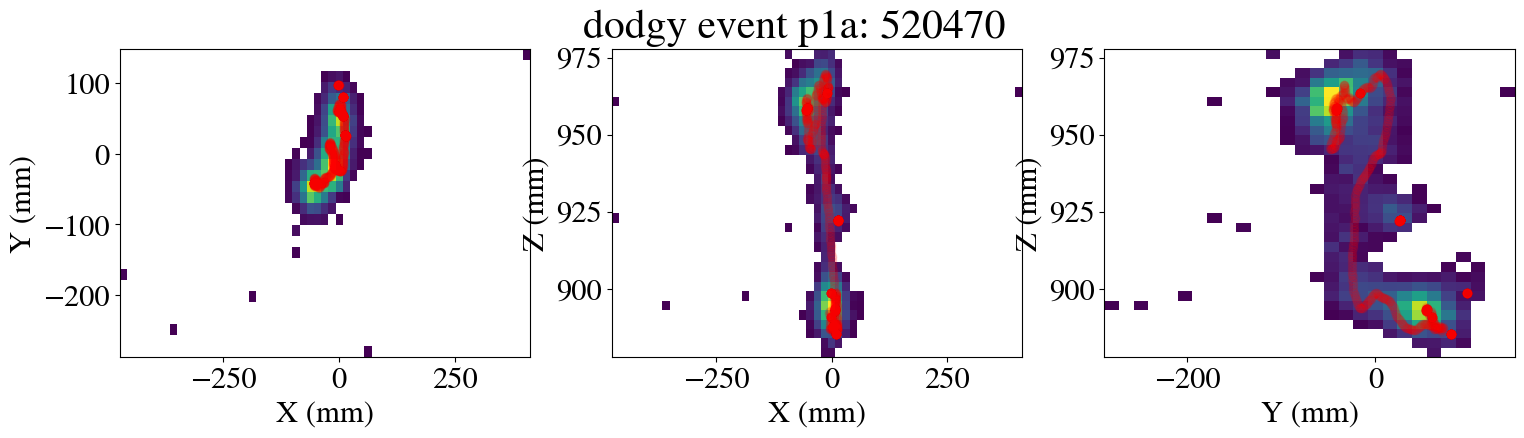

In [143]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(specific_event.X.min(), specific_event.X.max() + pitch, pitch)
yy = np.arange(specific_event.Y.min(), specific_event.Y.max() + pitch, pitch)
zz = specific_event.Z.unique()

axes[0].hist2d(specific_event.X, specific_event.Y, bins=[xx, yy], weights=specific_event.E*1000, cmin=0.0001);
axes[0].scatter(xt, yt, color='red', alpha = 0.1)
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(specific_event.X, specific_event.Z, bins=[xx, zz], weights=specific_event.E*1000, cmin=0.0001);
axes[1].scatter(xt, zt, color='red', alpha = 0.1)
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(specific_event.Y, specific_event.Z, bins=[yy, zz], weights=specific_event.E*1000, cmin=0.0001);
axes[2].scatter(yt, zt, color='red', alpha = 0.1)
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


fig.suptitle("dodgy event p1a: " + str(520470), fontsize=30)
#fig.savefig('plots_dodgy_events/' + str(evt_list[i]) + '_2D.png')
plt.show()


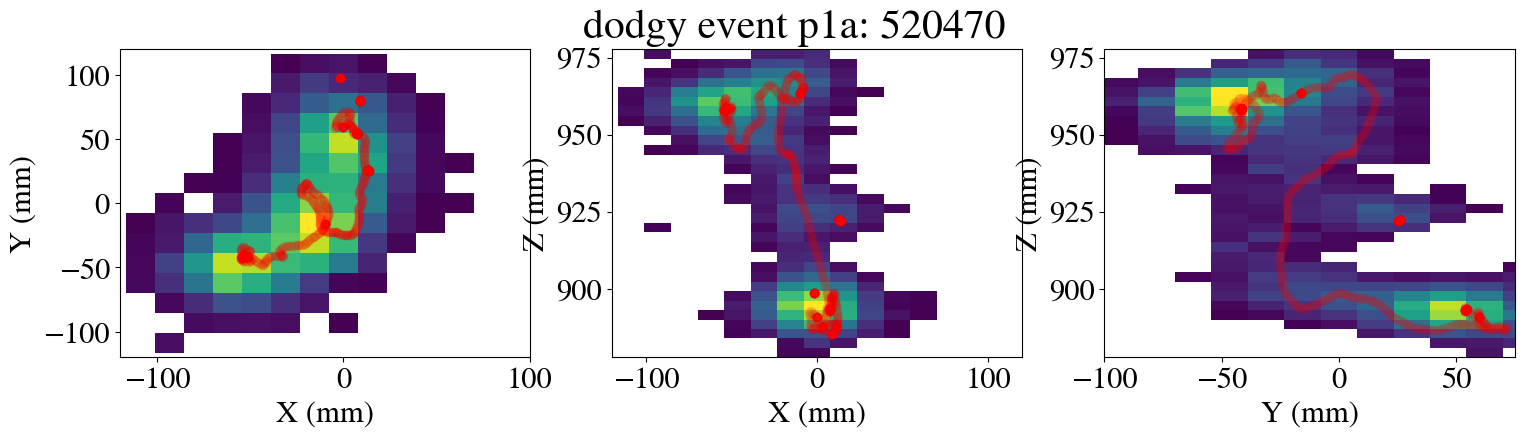

In [148]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(specific_event.X.min(), specific_event.X.max() + pitch, pitch)
yy = np.arange(specific_event.Y.min(), specific_event.Y.max() + pitch, pitch)
zz = specific_event.Z.unique()

axes[0].hist2d(specific_event.X, specific_event.Y, bins=[xx, yy], weights=specific_event.E*1000, cmin=0.0001);
axes[0].scatter(xt, yt, color='red', alpha = 0.1)
axes[0].set_xlim([-120, 100])
axes[0].set_ylim([-120, 120])
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(specific_event.X, specific_event.Z, bins=[xx, zz], weights=specific_event.E*1000, cmin=0.0001);
axes[1].scatter(xt, zt, color='red', alpha = 0.1)
axes[1].set_xlim([-120, 120])
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(specific_event.Y, specific_event.Z, bins=[yy, zz], weights=specific_event.E*1000, cmin=0.0001);
axes[2].scatter(yt, zt, color='red', alpha = 0.1)
axes[2].set_xlim([-100, 75])
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


fig.suptitle("dodgy event p1a: " + str(520470), fontsize=30)
#fig.savefig('plots_dodgy_events/' + str(evt_list[i]) + '_2D.png')
plt.show()
        

### collect the event numbers, and compare the MC of the two positrons to whats output via isaura

it seems like a lot of energy is being lost in these events! worrying.